# Прогнозные модели для молочного хозяйства «Вольный луг»

## Описание проекта

Вы работаете в IT-компании, которая выполняет на заказ проекты по машинному обучению. К вам обратился фермер, владелец молочного хозяйства «Вольный луг». Он хочет купить бурёнок, чтобы расширить поголовье стада коров. Для этого он заключил выгодный контракт с ассоциацией пастбищ «ЭкоФерма».

Условия позволяют фермеру очень тщательно отобрать коров. Он определяет качество молока по строгой методике, и при этом ему нужно выполнять свой план развития молочного хозяйства. Фермер хочет, чтобы каждая бурёнка давала не менее 6000 килограммов молока в год, а её надой был вкусным — строго по его критериям, ничуть не хуже. А продавцы и технологи так и норовят приукрасить своих коровок!

Поэтому он просит вас разработать модель машинного обучения, которая поможет ему управлять рисками и принимать объективное решение о покупке. «ЭкоФерма» готова предоставить подробные данные о своих коровах. Вам нужно создать две прогнозные модели для отбора бурёнок в поголовье:
1. Первая будет прогнозировать возможный удой коровы (целевой признак `Удой`);
2. Вторая — рассчитывать вероятность получить вкусное молоко от коровы (целевой признак `Вкус молока`).

С помощью модели нужно отобрать коров по двум критериям:
- средний удой за год — не менее 6000 килограммов;
- молоко должно быть вкусным.

## Загрузка данных

Импортируем необходимые библиотеки, объявим функции, зафиксируем рандомстейт.

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import phik
import seaborn as sns
from scipy import stats as st
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import (
    accuracy_score, 
    confusion_matrix, 
    mean_absolute_error, 
    mean_squared_error, 
    r2_score, recall_score, 
    precision_score
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler

In [7]:
def display_basic_info(df, count=5):
    display(df.head(count))
    display(df.info())


def display_box(data, title, xlabel, ax):
    data.plot(kind='box', vert=False, ax=ax)
    ax.set_title(f'Диаграмма размаха признака «{title}»')
    ax.set_xlabel(xlabel)
    ax.set_yticklabels([])
    ax.grid(axis='x', alpha=0.5)


def display_hist(data, bins, title, xlabel, ax):
    data.plot(kind='hist', bins=bins, edgecolor='white', linewidth=0.5, ax=ax)
    ax.set_title(f'Распределение признака «{title}»')
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Частота')


def display_donut(data, title, ax):
    data.value_counts().plot(kind='pie', autopct='%.0f%%', pctdistance=0.75, cmap='Set3', 
                             wedgeprops={'linewidth': 0.5, 'edgecolor': 'black', 'width': 0.5}, ax=ax)
    ax.set_title(title)
    ax.set_ylabel('')


def display_scatters(data, input_col_name, target_col_name, group_col_names, titles):
    fig = plt.figure(figsize=(12, 12))
    fig.subplots_adjust(wspace=0.4, hspace=0.4)
    for i, group_col_name in enumerate(group_col_names):
        ax = fig.add_subplot(3, 2, i + 1)
        for group_col_value in data[group_col_name].unique():
            filtered_data = data[data[group_col_name] == group_col_value]
            ax.scatter(x=filtered_data[input_col_name], y=filtered_data[target_col_name], 
                       label=group_col_value, s=20, alpha=0.5)
            ax.set_title(f'Рассеяние признаков «{target_col_name}» и «{input_col_name}»')
            ax.set_xlabel(titles[input_col_name])
            ax.set_ylabel(titles[target_col_name])
            ax.legend(title=titles[group_col_name])
            ax.grid(alpha=0.2)

In [8]:
%config InlineBackend.figure_format = 'retina'
pd.options.display.max_columns = False

In [9]:
RANDOM_STATE = 42

Считаем CSV-файлы с данными и сохраним их в датафреймы.

In [11]:
ferma_main = pd.read_csv('datasets/ferma_main.csv', sep=';', decimal=',')
display_basic_info(ferma_main)

id  Удой, кг  ЭКЕ (Энергетическая кормовая единица)  Сырой протеин, г  ...  Жирность,% Белок,% Вкус молока      Возраст
0   1      5863                                   14.2              1743  ...        3.58   3.076      вкусно  более_2_лет
1   2      5529                                   12.8              2138  ...        3.54   3.079      вкусно  менее_2_лет
2   3      5810                                   14.0              1854  ...        3.59   3.074   не вкусно  более_2_лет
3   4      5895                                   12.4              2012  ...        3.40   3.075   не вкусно  более_2_лет
4   5      5302                                   12.8              1675  ...        3.73   3.073      вкусно  менее_2_лет

[5 rows x 12 columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 12 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id                                     634 non-null    int64  
 1   Удой, кг                               634 non-null    int64  
 2   ЭКЕ (Энергетическая кормовая единица)  634 non-null    float64
 3   Сырой протеин, г                       634 non-null    int64  
 4   СПО (Сахаро-протеиновое соотношение)   634 non-null    float64
 5   Порода                                 634 non-null    object 
 6   Тип пастбища                           634 non-null    object 
 7   порода папы_быка                       634 non-null    object 
 8   Жирность,%                             634 non-null    float64
 9   Белок,%                                634 non-null    float64
 10  Вкус молока                            634 non-null    object 
 11  Возрас

None

In [12]:
ferma_dad = pd.read_csv('datasets/ferma_dad.csv', sep=';')
display_basic_info(ferma_dad)

id  Имя Папы
0   1    Буйный
1   2  Соловчик
2   3     Барин
3   4    Буйный
4   5     Барин

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        629 non-null    int64 
 1   Имя Папы  629 non-null    object
dtypes: int64(1), object(1)
memory usage: 10.0+ KB


None

In [13]:
cow_buy = pd.read_csv('datasets/cow_buy.csv', sep=';', decimal=',')
display_basic_info(cow_buy)

Порода Тип пастбища порода папы_быка  Имя_папы  Текущая_жирность,%  Текущий_уровень_белок,%      Возраст
0   Вис Бик Айдиал    холмистое           Айдиал  Геркулес                3.58                    3.076  более_2_лет
1   Вис Бик Айдиал    равнинное          Соверин    Буйный                3.54                    3.081  менее_2_лет
2  РефлешнСоверинг    равнинное          Соверин     Барин                3.59                    3.074  более_2_лет
3  РефлешнСоверинг    холмистое           Айдиал    Буйный                3.40                    3.061  более_2_лет
4  РефлешнСоверинг    равнинное           Айдиал    Буйный                3.64                    3.074  более_2_лет

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Порода                   20 non-null     object 
 1   Тип пастбища             20 non-null     object 
 2   порода папы_быка         20 non-null     object 
 3   Имя_папы                 20 non-null     object 
 4   Текущая_жирность,%       20 non-null     float64
 5   Текущий_уровень_белок,%  20 non-null     float64
 6   Возраст                  20 non-null     object 
dtypes: float64(2), object(5)
memory usage: 1.2+ KB


None

##  Предобработка данных

### Названия столбцов

Заменим названия столбцов в загруженных датафреймах.

In [17]:
ferma_main.columns = ['id', 'удой', 'эке_корма', 'протеин_в_корме', 'спо_корма', 'порода', 
                      'пастбище', 'порода_папы', 'жирность_молока', 'белок_в_молоке', 'вкус_молока', 'возраст']
ferma_main.head(1)

id  удой  эке_корма  протеин_в_корме  спо_корма          порода   пастбище порода_папы  жирность_молока  белок_в_молоке вкус_молока      возраст
0   1  5863       14.2             1743       0.89  Вис Бик Айдиал  Равнинное      Айдиал             3.58           3.076      вкусно  более_2_лет

In [18]:
ferma_dad.columns = ['id', 'имя_папы']
ferma_dad.head(1)

id имя_папы
0   1   Буйный

In [19]:
cow_buy.columns = ['порода', 'пастбище', 'порода_папы', 'имя_папы', 'жирность_молока', 'белок_в_молоке', 'возраст']
cow_buy.head(1)

порода   пастбище порода_папы  имя_папы  жирность_молока  белок_в_молоке      возраст
0  Вис Бик Айдиал  холмистое      Айдиал  Геркулес             3.58           3.076  более_2_лет

### Данные о стаде фермера

Предобработаем данные о стаде фермера на текущий момент. Для начала проверим явные дубликаты.

In [22]:
ferma_main.duplicated().sum()

5

Есть явные дубликаты, удалим их.

In [24]:
ferma_main = ferma_main.drop_duplicates()

Проверим пропуски в данных.

In [26]:
ferma_main.isna().sum().sum()

0

Пропусков в данных нет.

Приведем значения в столбце с типом пастбища `пастбище` к нижнему регистру (как в датафрейме с данными о коровах «ЭкоФермы», которых фермер хочет изучить перед покупкой), посмотрим на уникальные значения в этом столбце.

In [29]:
ferma_main['пастбище'] = ferma_main['пастбище'].str.lower()
ferma_main['пастбище'].unique()

array(['равнинное', 'равнинные', 'холмистое'], dtype=object)

Значения «равнинное» и «равнинные» в столбце с типом пастбища `пастбище` явно означают одно и то же. Объединим их.

In [31]:
ferma_main['пастбище'] = ferma_main['пастбище'].str.replace('равнинные', 'равнинное')

Посмотрим на уникальные значения в столбце с породой папы коровы `порода_папы`.

In [33]:
ferma_main['порода_папы'].unique()

array(['Айдиал', 'Соверин', 'Айдиалл'], dtype=object)

Значения «Айдиал» и «Айдиалл» в столбце с породой папы коровы `порода_папы` явно означают одно и то же. Объединим их.

In [35]:
ferma_main['порода_папы'] = ferma_main['порода_папы'].str.replace('Айдиалл', 'Айдиал')

Изменим порядок столбцов.

In [37]:
ferma_main = ferma_main[['id', 'возраст', 'порода', 'порода_папы', 'пастбище', 
                         'эке_корма', 'протеин_в_корме', 'спо_корма', 
                         'жирность_молока', 'белок_в_молоке', 'удой', 'вкус_молока']]

Посмотрим на результат.

In [39]:
display_basic_info(ferma_main)

id      возраст           порода порода_папы   пастбище  эке_корма  протеин_в_корме  спо_корма  жирность_молока  белок_в_молоке  удой вкус_молока
0   1  более_2_лет   Вис Бик Айдиал      Айдиал  равнинное       14.2             1743      0.890             3.58           3.076  5863      вкусно
1   2  менее_2_лет   Вис Бик Айдиал     Соверин  равнинное       12.8             2138      0.890             3.54           3.079  5529      вкусно
2   3  более_2_лет  РефлешнСоверинг     Соверин  холмистое       14.0             1854      0.885             3.59           3.074  5810   не вкусно
3   4  более_2_лет  РефлешнСоверинг      Айдиал  холмистое       12.4             2012      0.885             3.40           3.075  5895   не вкусно
4   5  менее_2_лет   Вис Бик Айдиал     Соверин  равнинное       12.8             1675      0.885             3.73           3.073  5302      вкусно

<class 'pandas.core.frame.DataFrame'>
Index: 629 entries, 0 to 628
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               629 non-null    int64  
 1   возраст          629 non-null    object 
 2   порода           629 non-null    object 
 3   порода_папы      629 non-null    object 
 4   пастбище         629 non-null    object 
 5   эке_корма        629 non-null    float64
 6   протеин_в_корме  629 non-null    int64  
 7   спо_корма        629 non-null    float64
 8   жирность_молока  629 non-null    float64
 9   белок_в_молоке   629 non-null    float64
 10  удой             629 non-null    int64  
 11  вкус_молока      629 non-null    object 
dtypes: float64(4), int64(3), object(5)
memory usage: 63.9+ KB


None

В результате предобработки мы получили датафрейм с данными о стаде фермера на текущий момент `ferma_main`, очищенный явных и неявных дубликатов. Описание данных:
- `возраст` — возраст коровы, бинарный признак.
- `порода` — порода коровы.
- `порода_папы` — порода папы коровы.
- `пастбище` — тип пастбища — ландшафт лугов, на которых паслась корова.
- `эке_корма` — ЭКЕ (энергетическая кормовая единица), показатель питательности корма коровы.
- `протеин_в_корме` — содержание сырого протеина в корме (в граммах).
- `спо_корма` — СПО (сахаро-протеиновое соотношение), отношение сахара к протеину в корме коровы.
- `жирность_молока` — содержание жиров в молоке (в процентах).
- `белок_в_молоке` — содержание белков в молоке (в процентах).
- `удой` — масса молока, которую корова даёт в год (в килограммах).
- `вкус_молока` — оценка вкуса молока по личным критериям фермера, бинарный признак.

In [41]:
# словарь с названиями столбцов для использования при построении графиков
ferma_main_features = {'возраст': 'Возраст коровы', 
                       'порода': 'Порода коровы',
                       'порода_папы': 'Порода папы коровы', 
                       'пастбище': 'Тип пастбища', 
                       'эке_корма': 'Питательность корма, ЭКЕ',
                       'протеин_в_корме': 'Содержание сырого протеина в корме, г', 
                       'спо_корма': 'Сахаро-протеиновое соотношение в корме',
                       'жирность_молока': 'Содержание жиров в молоке, %', 
                       'белок_в_молоке': 'Содержание белков в молоке, %',
                       'удой': 'Удой, кг в год', 
                       'вкус_молока': 'Вкус молока'}

### Данные о коровах «ЭкоФермы»

Предобработаем данные о коровах «ЭкоФермы», которых фермер хочет изучить перед покупкой. Для начала проверим явные дубликаты.

In [44]:
cow_buy.duplicated().sum()

4

Есть явные дубликаты. Однако есть вероятность, что параметры разных коров просто совпали. Поскольку в датасете нет идентификаторов, по которым можно было бы сделать однозначный вывод о дубликатах, удалять их не будем.

Проверим пропуски в данных.

In [47]:
cow_buy.isna().sum().sum()

0

Пропусков в данных нет.

Изменим порядок столбцов.

In [50]:
cow_buy = cow_buy[['возраст', 'порода', 'порода_папы', 'имя_папы', 'пастбище', 
                   'жирность_молока', 'белок_в_молоке']]

Посмотрим на результат.

In [52]:
display_basic_info(cow_buy)

возраст           порода порода_папы  имя_папы   пастбище  жирность_молока  белок_в_молоке
0  более_2_лет   Вис Бик Айдиал      Айдиал  Геркулес  холмистое             3.58           3.076
1  менее_2_лет   Вис Бик Айдиал     Соверин    Буйный  равнинное             3.54           3.081
2  более_2_лет  РефлешнСоверинг     Соверин     Барин  равнинное             3.59           3.074
3  более_2_лет  РефлешнСоверинг      Айдиал    Буйный  холмистое             3.40           3.061
4  более_2_лет  РефлешнСоверинг      Айдиал    Буйный  равнинное             3.64           3.074

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   возраст          20 non-null     object 
 1   порода           20 non-null     object 
 2   порода_папы      20 non-null     object 
 3   имя_папы         20 non-null     object 
 4   пастбище         20 non-null     object 
 5   жирность_молока  20 non-null     float64
 6   белок_в_молоке   20 non-null     float64
dtypes: float64(2), object(5)
memory usage: 1.2+ KB


None

В результате предобработки мы получили датафрейм с данные о коровах «ЭкоФермы», которых фермер хочет изучить перед покупкой, `cow_buy`, очищенный явных дубликатов и дополненный данными о параметрах корма. Описание данных:
- `возраст` — возраст коровы, бинарный признак.
- `порода` — порода коровы.
- `порода_папы` — порода папы коровы.
- `имя_папы` — имя папы коровы.
- `пастбище` — тип пастбища — ландшафт лугов, на которых паслась корова.
- `эке_корма` — ЭКЕ (энергетическая кормовая единица), показатель питательности корма коровы.
- `протеин_в_корме` — содержание сырого протеина в корме (в граммах).
- `спо_корма` — СПО (сахаро-протеиновое соотношение), отношение сахара к протеину в корме коровы.
- `жирность_молока` — содержание жиров в молоке (в процентах).
- `белок_в_молоке` — содержание белков в молоке (в процентах).

### Результаты предобработки

В результате предобработки данных:
- Объединены данные о стаде фермера на текущий момент и данные об имя папы каждой коровы в стаде фермера.
- Удалены явные дубликаты в данных о стаде фермера на текущий момент (~0.8% от общего числа записей), обработаны неявные дубликаты.
- Обнаружены (но не удалены) явные дубликаты в данных о коровах «ЭкоФермы», которых фермер хочет изучить перед покупкой (~20% от общего числа записей).

## Исследовательский анализ данных

В данных о стаде фермера на текущий момент есть количественные и категориальные признаки. Изучим их по отдельности.

### Количественные признаки

Посмотрим на числовое описание количественных признаков в датафрейме `ferma_main`.

In [60]:
num_col_names = ['эке_корма', 'протеин_в_корме', 'спо_корма', 'жирность_молока', 'белок_в_молоке', 'удой']
ferma_main[num_col_names].describe().T

count         mean          std       min       25%       50%       75%        max
эке_корма        629.0    14.543879     1.306408    10.900    13.500    14.700    15.600     16.800
протеин_в_корме  629.0  1923.364070   182.956251  1660.000  1771.000  1888.000  2062.000   2349.000
спо_корма        629.0     0.913116     0.032203     0.840     0.890     0.930     0.940      0.960
жирность_молока  629.0     3.603657     0.168656     2.990     3.590     3.650     3.720      3.750
белок_в_молоке   629.0     3.075671     0.002549     3.069     3.074     3.076     3.077      3.085
удой             629.0  6188.750397  1644.795489  5204.000  5751.000  6133.000  6501.000  45616.000

Построим диаграммы размаха количественных признаков.

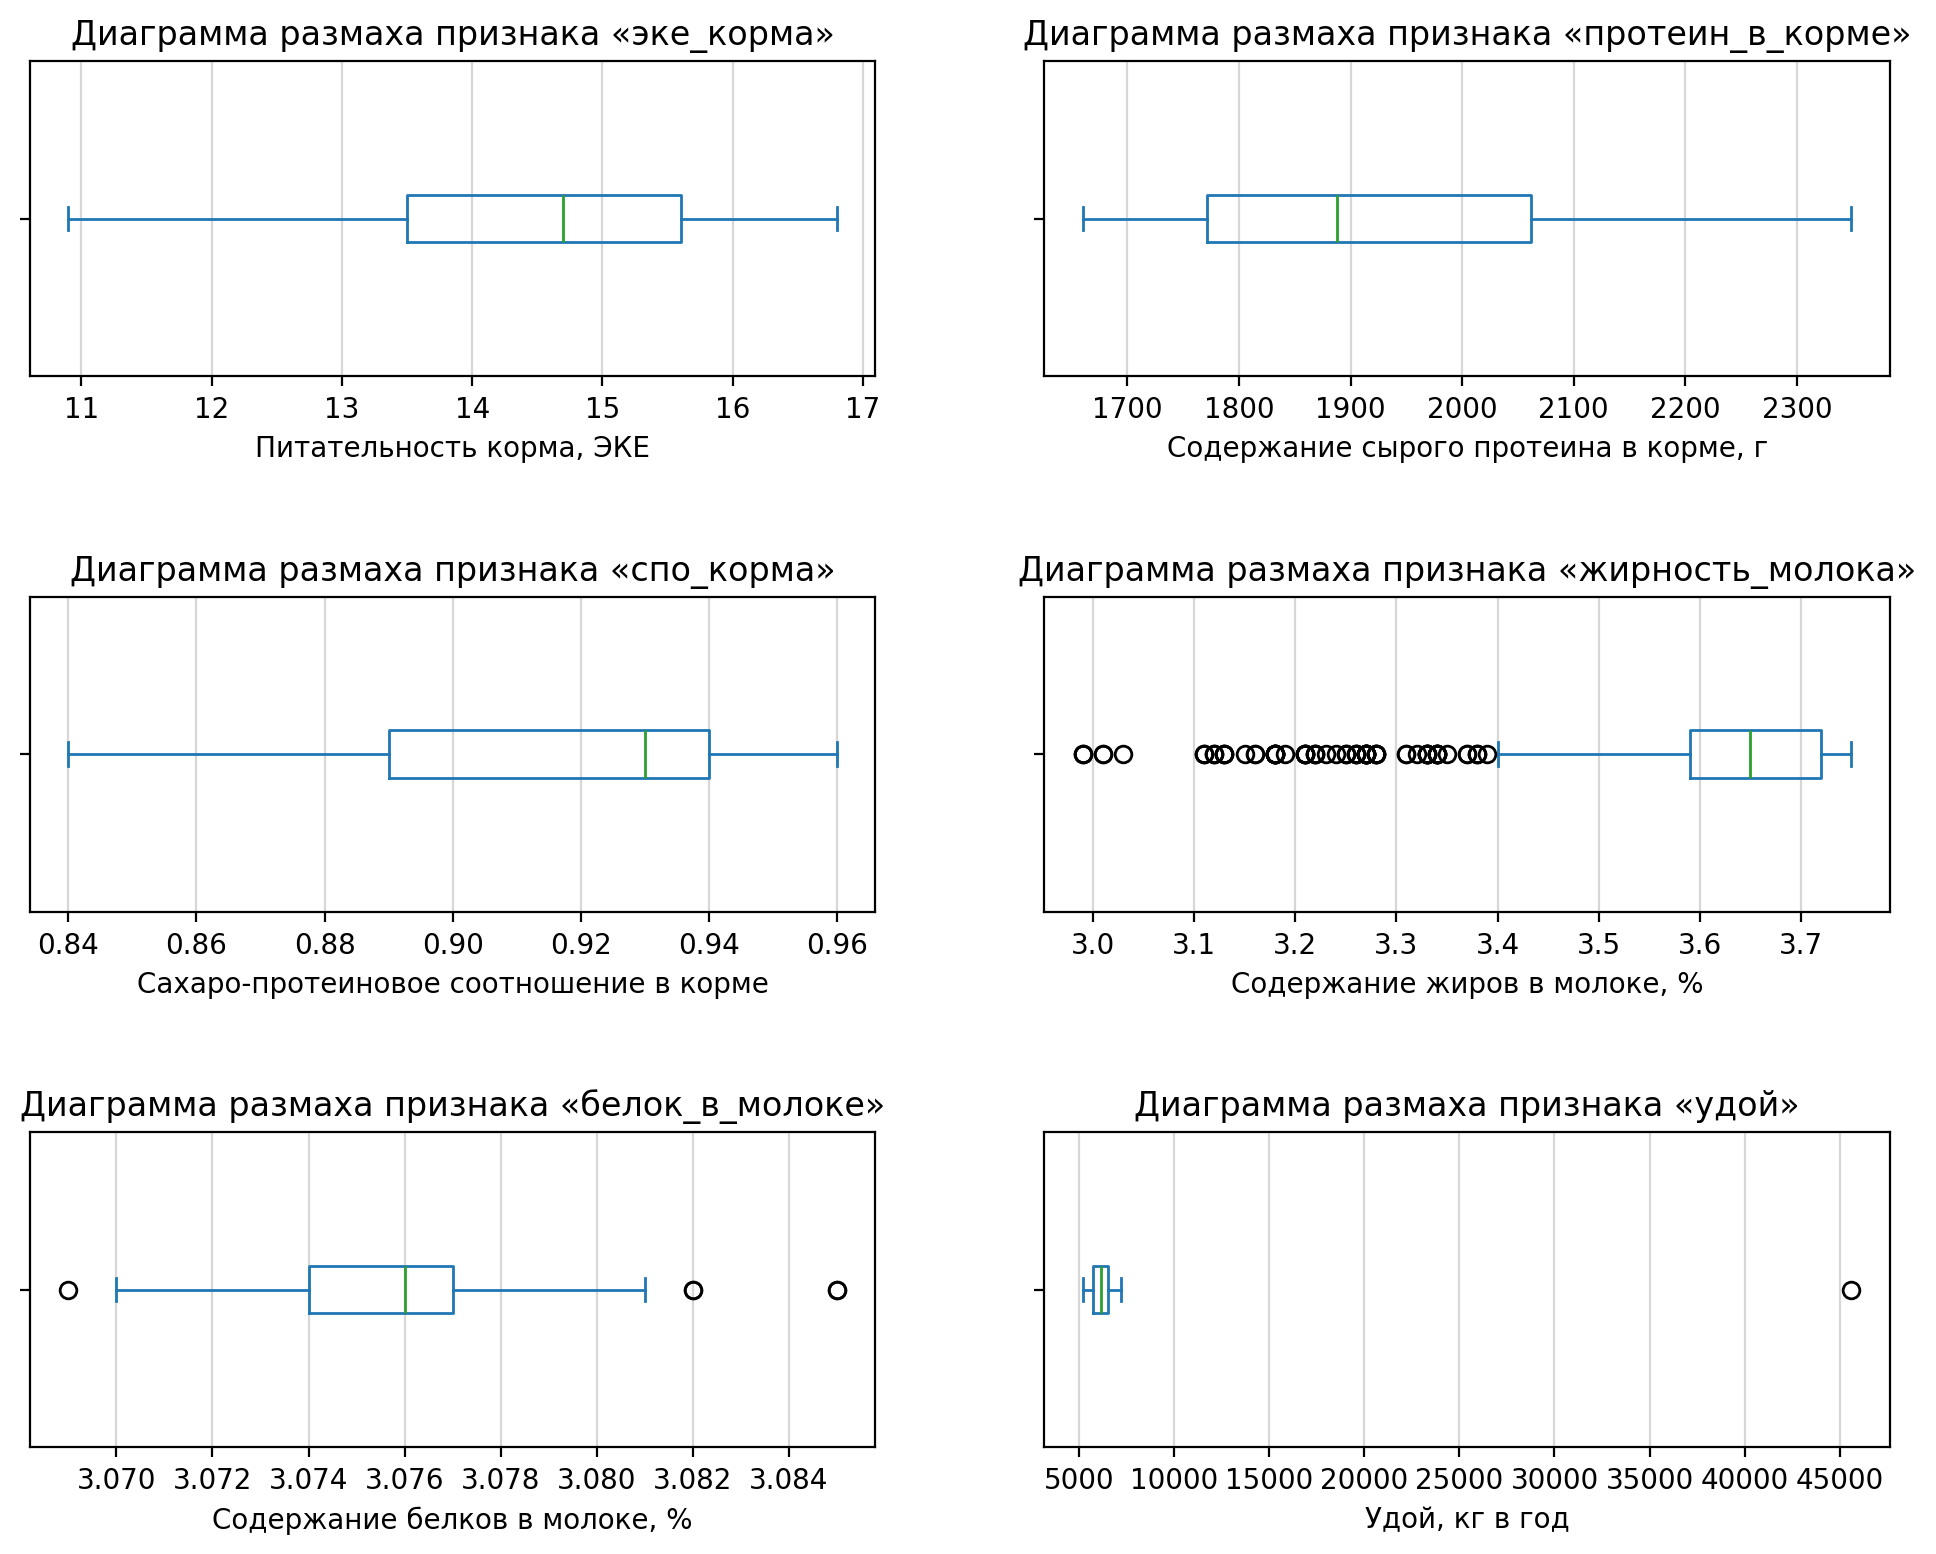

In [62]:
fig = plt.figure(figsize=(12, 9))
fig.subplots_adjust(wspace=0.2, hspace=0.7)
for i, col_name in enumerate(num_col_names):
    ax = fig.add_subplot(3, 2, i + 1)
    display_box(ferma_main[col_name], col_name, ferma_main_features[col_name], ax)

На диаграммах размаха видно, что признаки с характеристиками корма `эке_корма`, `протеин_в_корме` и `спо_корма` не содержат выбросов. Однако в признаках с характеристиками молока `жирность_молока`, `белок_в_молоке` и `удой` есть выбросы — определим доли таких записей от общего числа записей.

In [64]:
outliers = ferma_main.query('жирность_молока < 3.4').shape[0] / ferma_main.shape[0]
f'Выбросы в жирности молока: {outliers * 100:.2f}%'

'Выбросы в жирности молока: 13.83%'

In [65]:
outliers = ferma_main.query('белок_в_молоке < 3.07 or белок_в_молоке > 3.081').shape[0] / ferma_main.shape[0]
f'Выбросы в белке в молоке: {outliers * 100:.2f}%'

'Выбросы в белке в молоке: 0.79%'

In [66]:
outliers = ferma_main.query('удой > 45000').shape[0] / ferma_main.shape[0]
f'Выбросы в удое: {outliers * 100:.2f}%'

'Выбросы в удое: 0.16%'

Записей с выбросами в `жирность_молока` ~14% — слишком большой процент, удалять не будем. При этом записей с выбросами в `белок_в_молоке` и в `удой` суммарно ~1% — удалим эти записи.

In [68]:
ferma_main = ferma_main.query('белок_в_молоке >= 3.07 and белок_в_молоке <= 3.081')
ferma_main = ferma_main.query('удой <= 45000')

Посмотрим на числовое описание удоя после удаления записей с выбросами.

In [70]:
ferma_main[['удой']].describe().T

count         mean         std     min     25%     50%     75%     max
удой  623.0  6127.232745  476.314531  5204.0  5748.5  6133.0  6501.0  7222.0

Отдельно стоит отметить, что более половины коров дают более 6000 килограммов молока в год.

Построим диаграммы распределения количественных признаков.

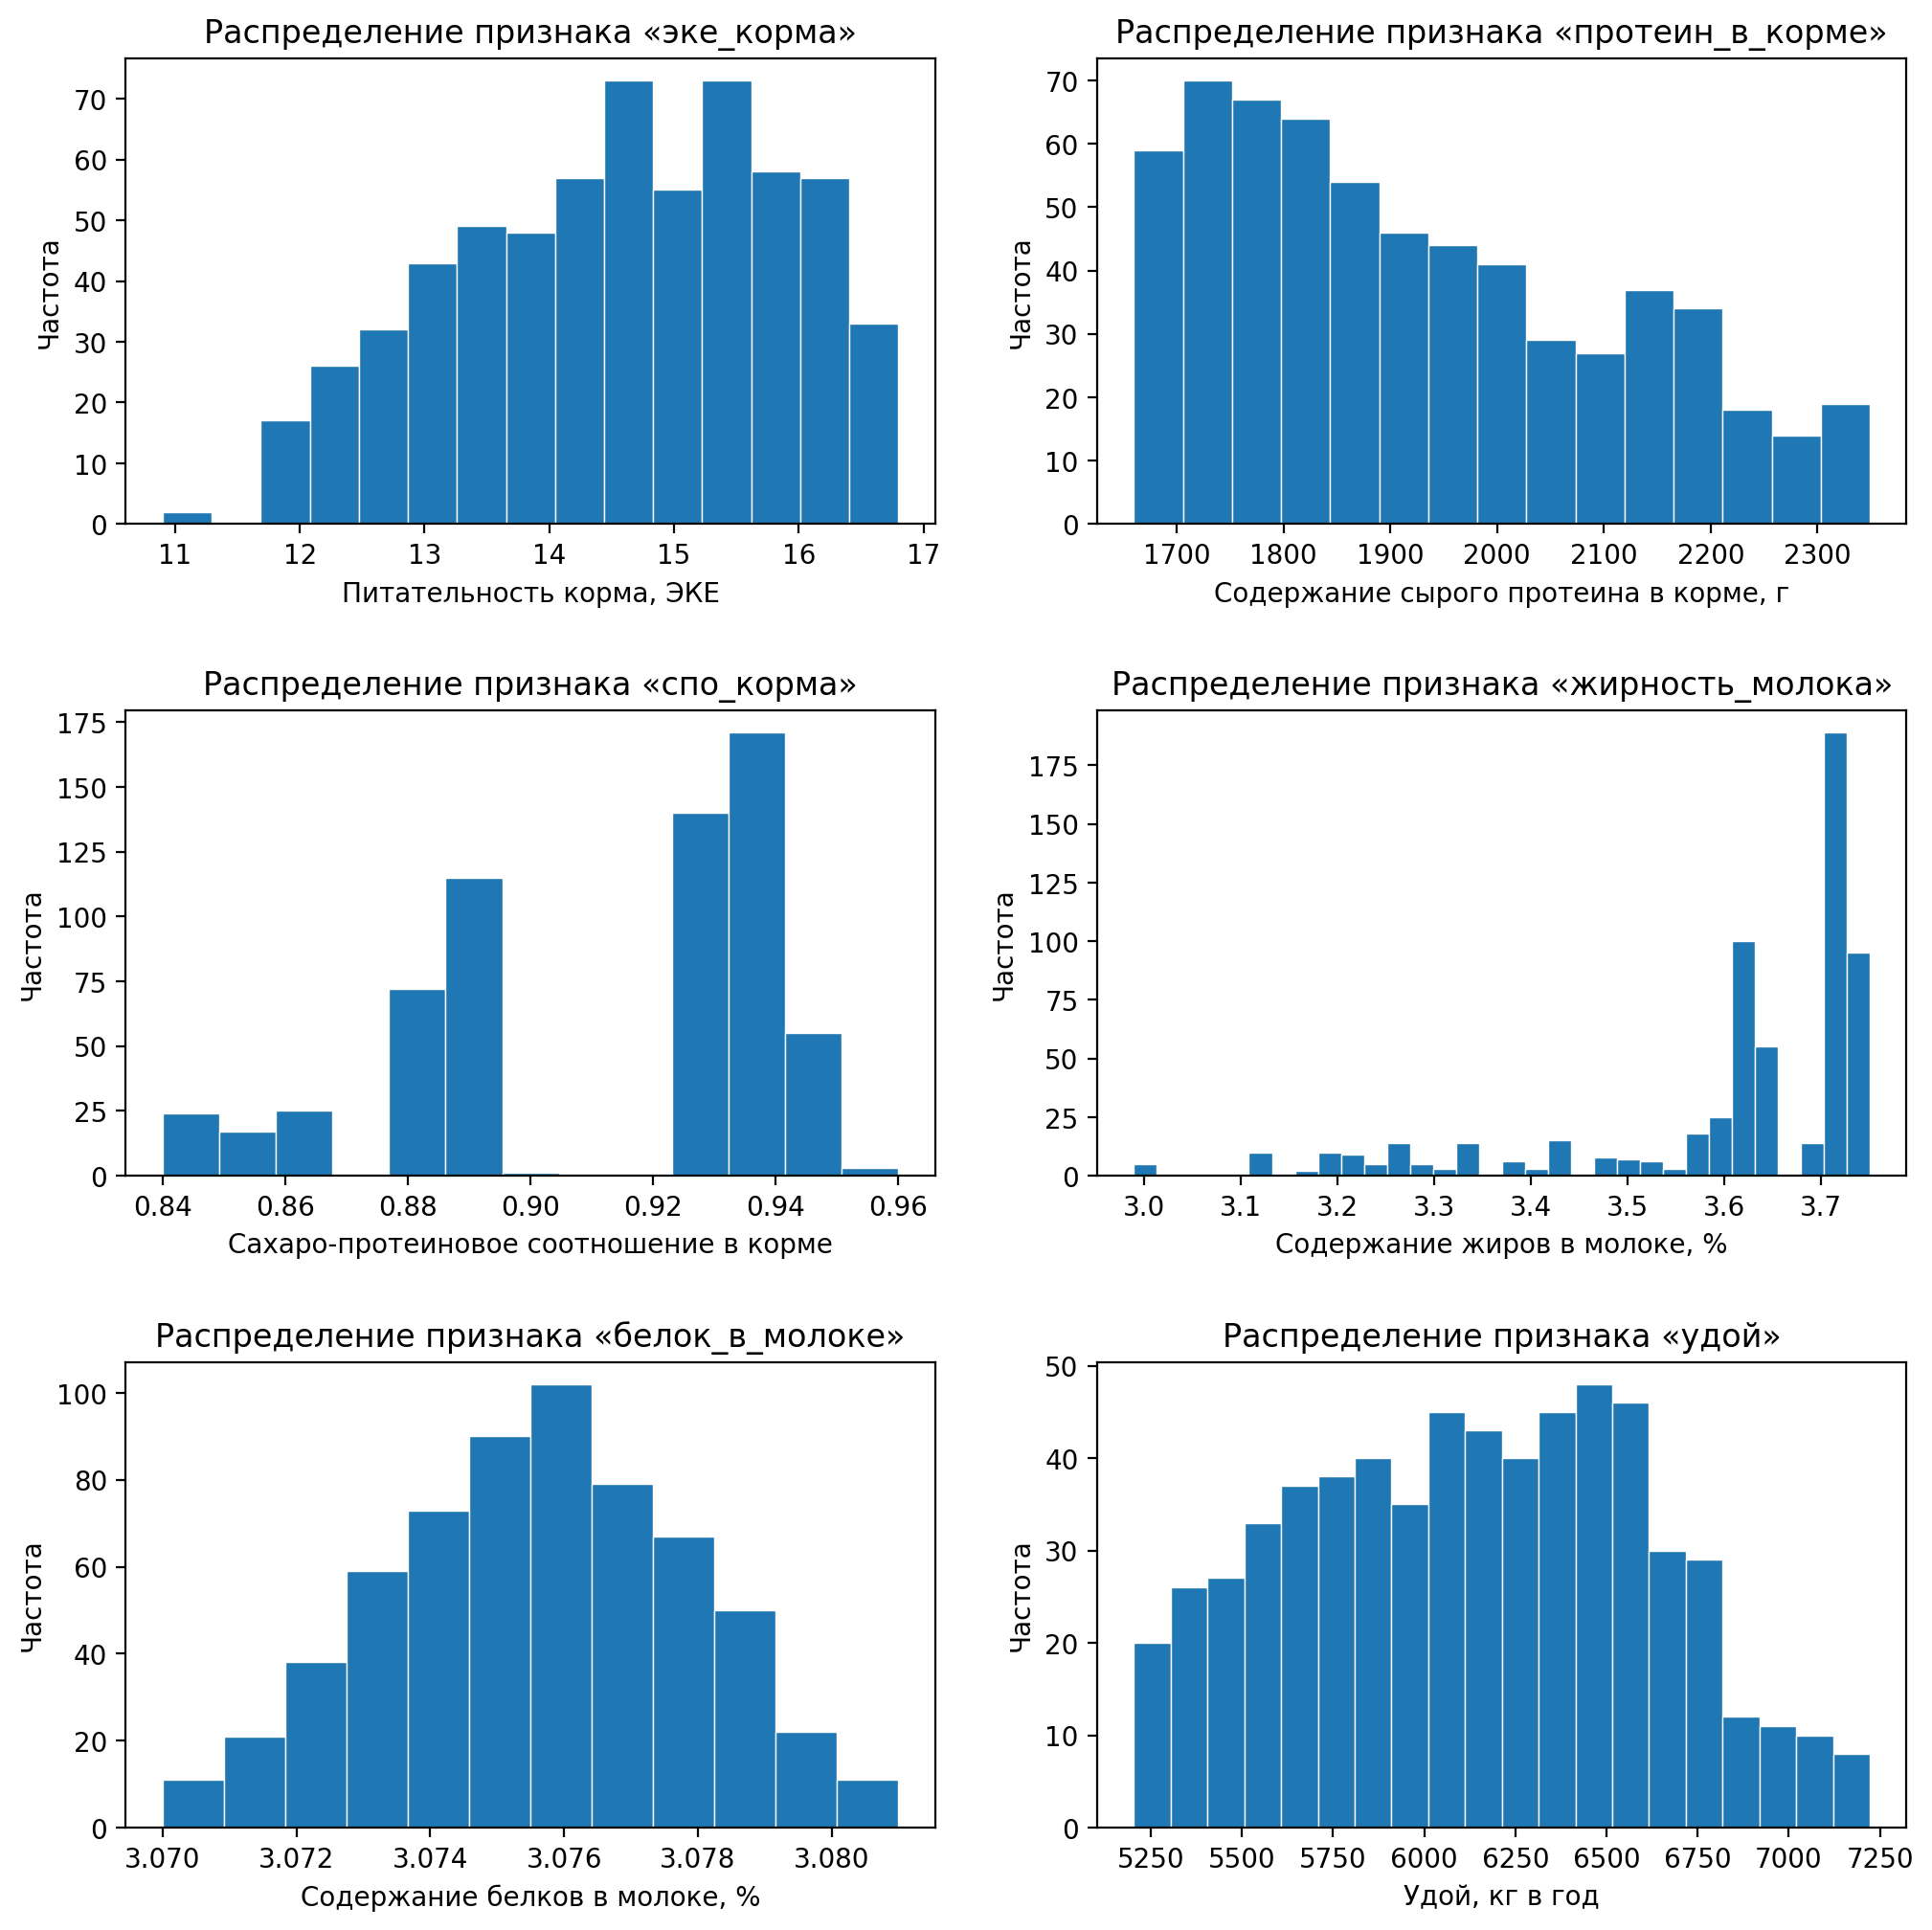

In [73]:
bins = [15, 15, 13, 32, 12, 20]  # список с количеством корзин

fig = plt.figure(figsize=(12, 12))
fig.subplots_adjust(wspace=0.2, hspace=0.4)
for i, col_name in enumerate(num_col_names):
    ax = fig.add_subplot(3, 2, i + 1)
    display_hist(ferma_main[col_name], bins[i], col_name, ferma_main_features[col_name], ax)

На диаграммах распределения особых аномалий не наблюдается. Не все количественные признаки распределены нормально. Заметно, что сахаро-протеиновое соотношение в корме можно разделить на две группы — «высокое» и «низкое», также заметны несколько групп значений в содержании жиров в молоке.

### Категориальные признаки

Посмотрим на числовое описание категориальных признаков в датафрейме `ferma_main`.

In [77]:
cat_col_names = ['возраст', 'порода', 'порода_папы', 'пастбище', 'вкус_молока']
ferma_main[cat_col_names].describe().T

count unique             top freq
возраст       623      2     более_2_лет  514
порода        623      2  Вис Бик Айдиал  368
порода_папы   623      2          Айдиал  314
пастбище      623      2       холмистое  348
вкус_молока   623      2          вкусно  366

Посмотрим на распределения категориальных признаков.

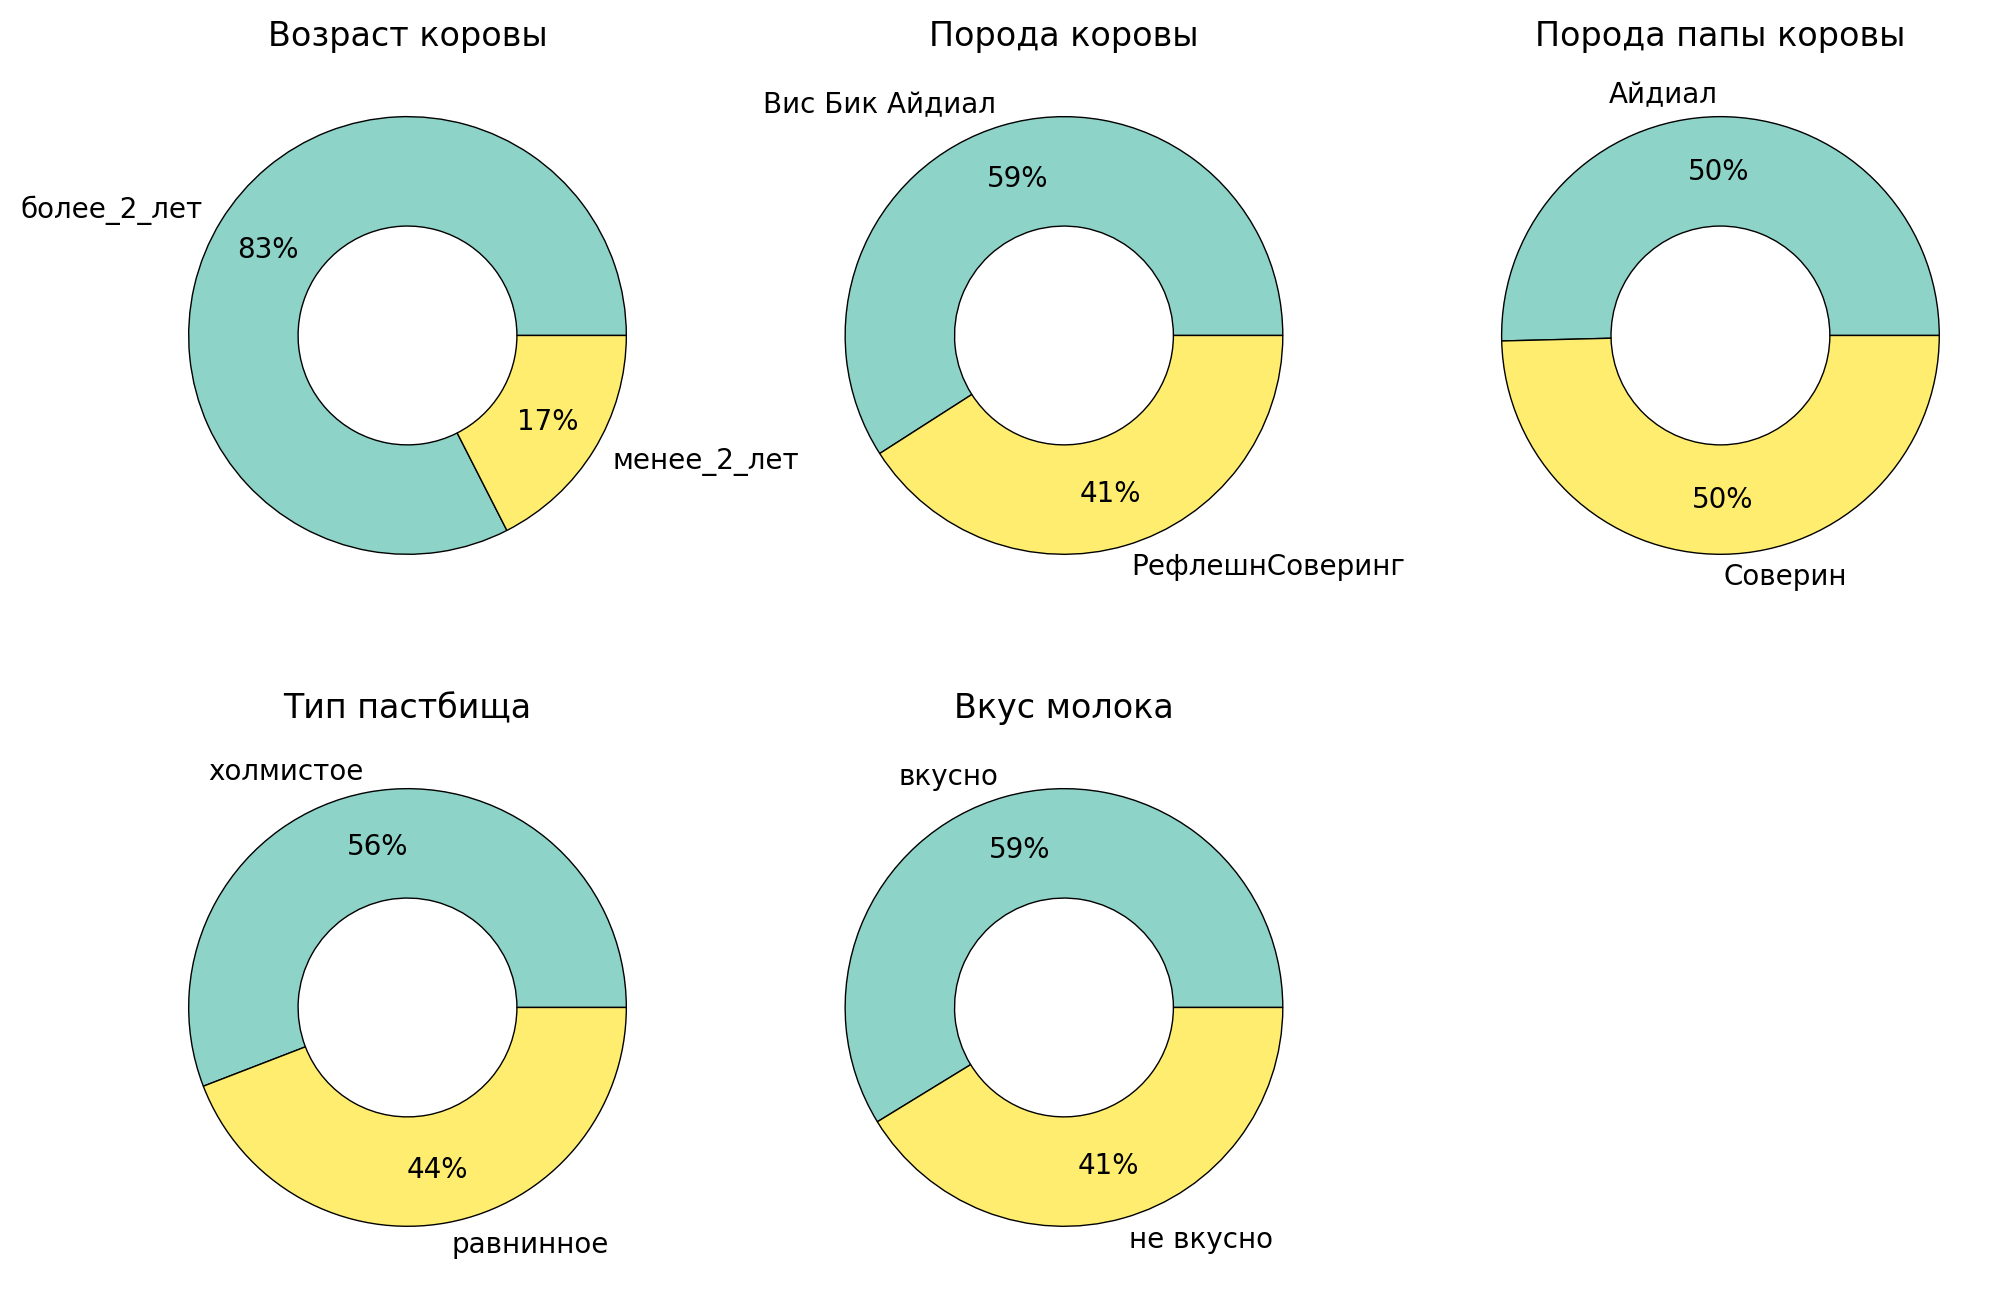

In [79]:
fig = plt.figure(figsize=(12, 8))
for i, col_name in enumerate(cat_col_names):
    ax = fig.add_subplot(2, 3, i + 1)
    display_donut(ferma_main[col_name], ferma_main_features[col_name], ax)

На диаграммах видно, что породы коров и породы их пап, типы пастбищ и вкус молока распределены в примерно равных долях. Доли коров старше и младше 2 лет существенно отличаются и составляют 83% и 17% соответственно. Отдельно стоит отметить, что более половины коров дают вкусное (по личным критериям фермера) молоко.

### Результаты исследовательского анализа

К результатам исследовательского анализа данных о стаде фермера на текущий момент можно отнести:
- Удалено ~1% записей с выбросами в значениях нескольких количественных признаков (содержание белков в молоке и удой).
- У количественных признаков разные диапазоны значений — не обойтись без масштабирования данных.
- Не все количественные признаки распределены нормально. Заметно, что сахаро-протеиновое соотношение в корме можно разделить на две группы — «высокое» и «низкое», также заметны несколько групп значений в содержании жиров в молоке.
- Все категориальные признаки — бинарные.
- Удой коров в стаде фермера находится в границах от 5204 до 7222 кг в год, средний удой — 6127 кг в год.
- 59% коров в стаде фермера дают вкусное (по личным критериям фермера) молоко, 41% — не вкусное.

## Корреляционный анализ

### Матрица корреляций

Поскольку корреляция Пирсона не подходит для категориальных признаков, рассчитаем коэффициенты корреляции Фи  между всеми признаками в датафрейме `ferma_main`. Посмотрим тепловую карту матрицы корреляций.

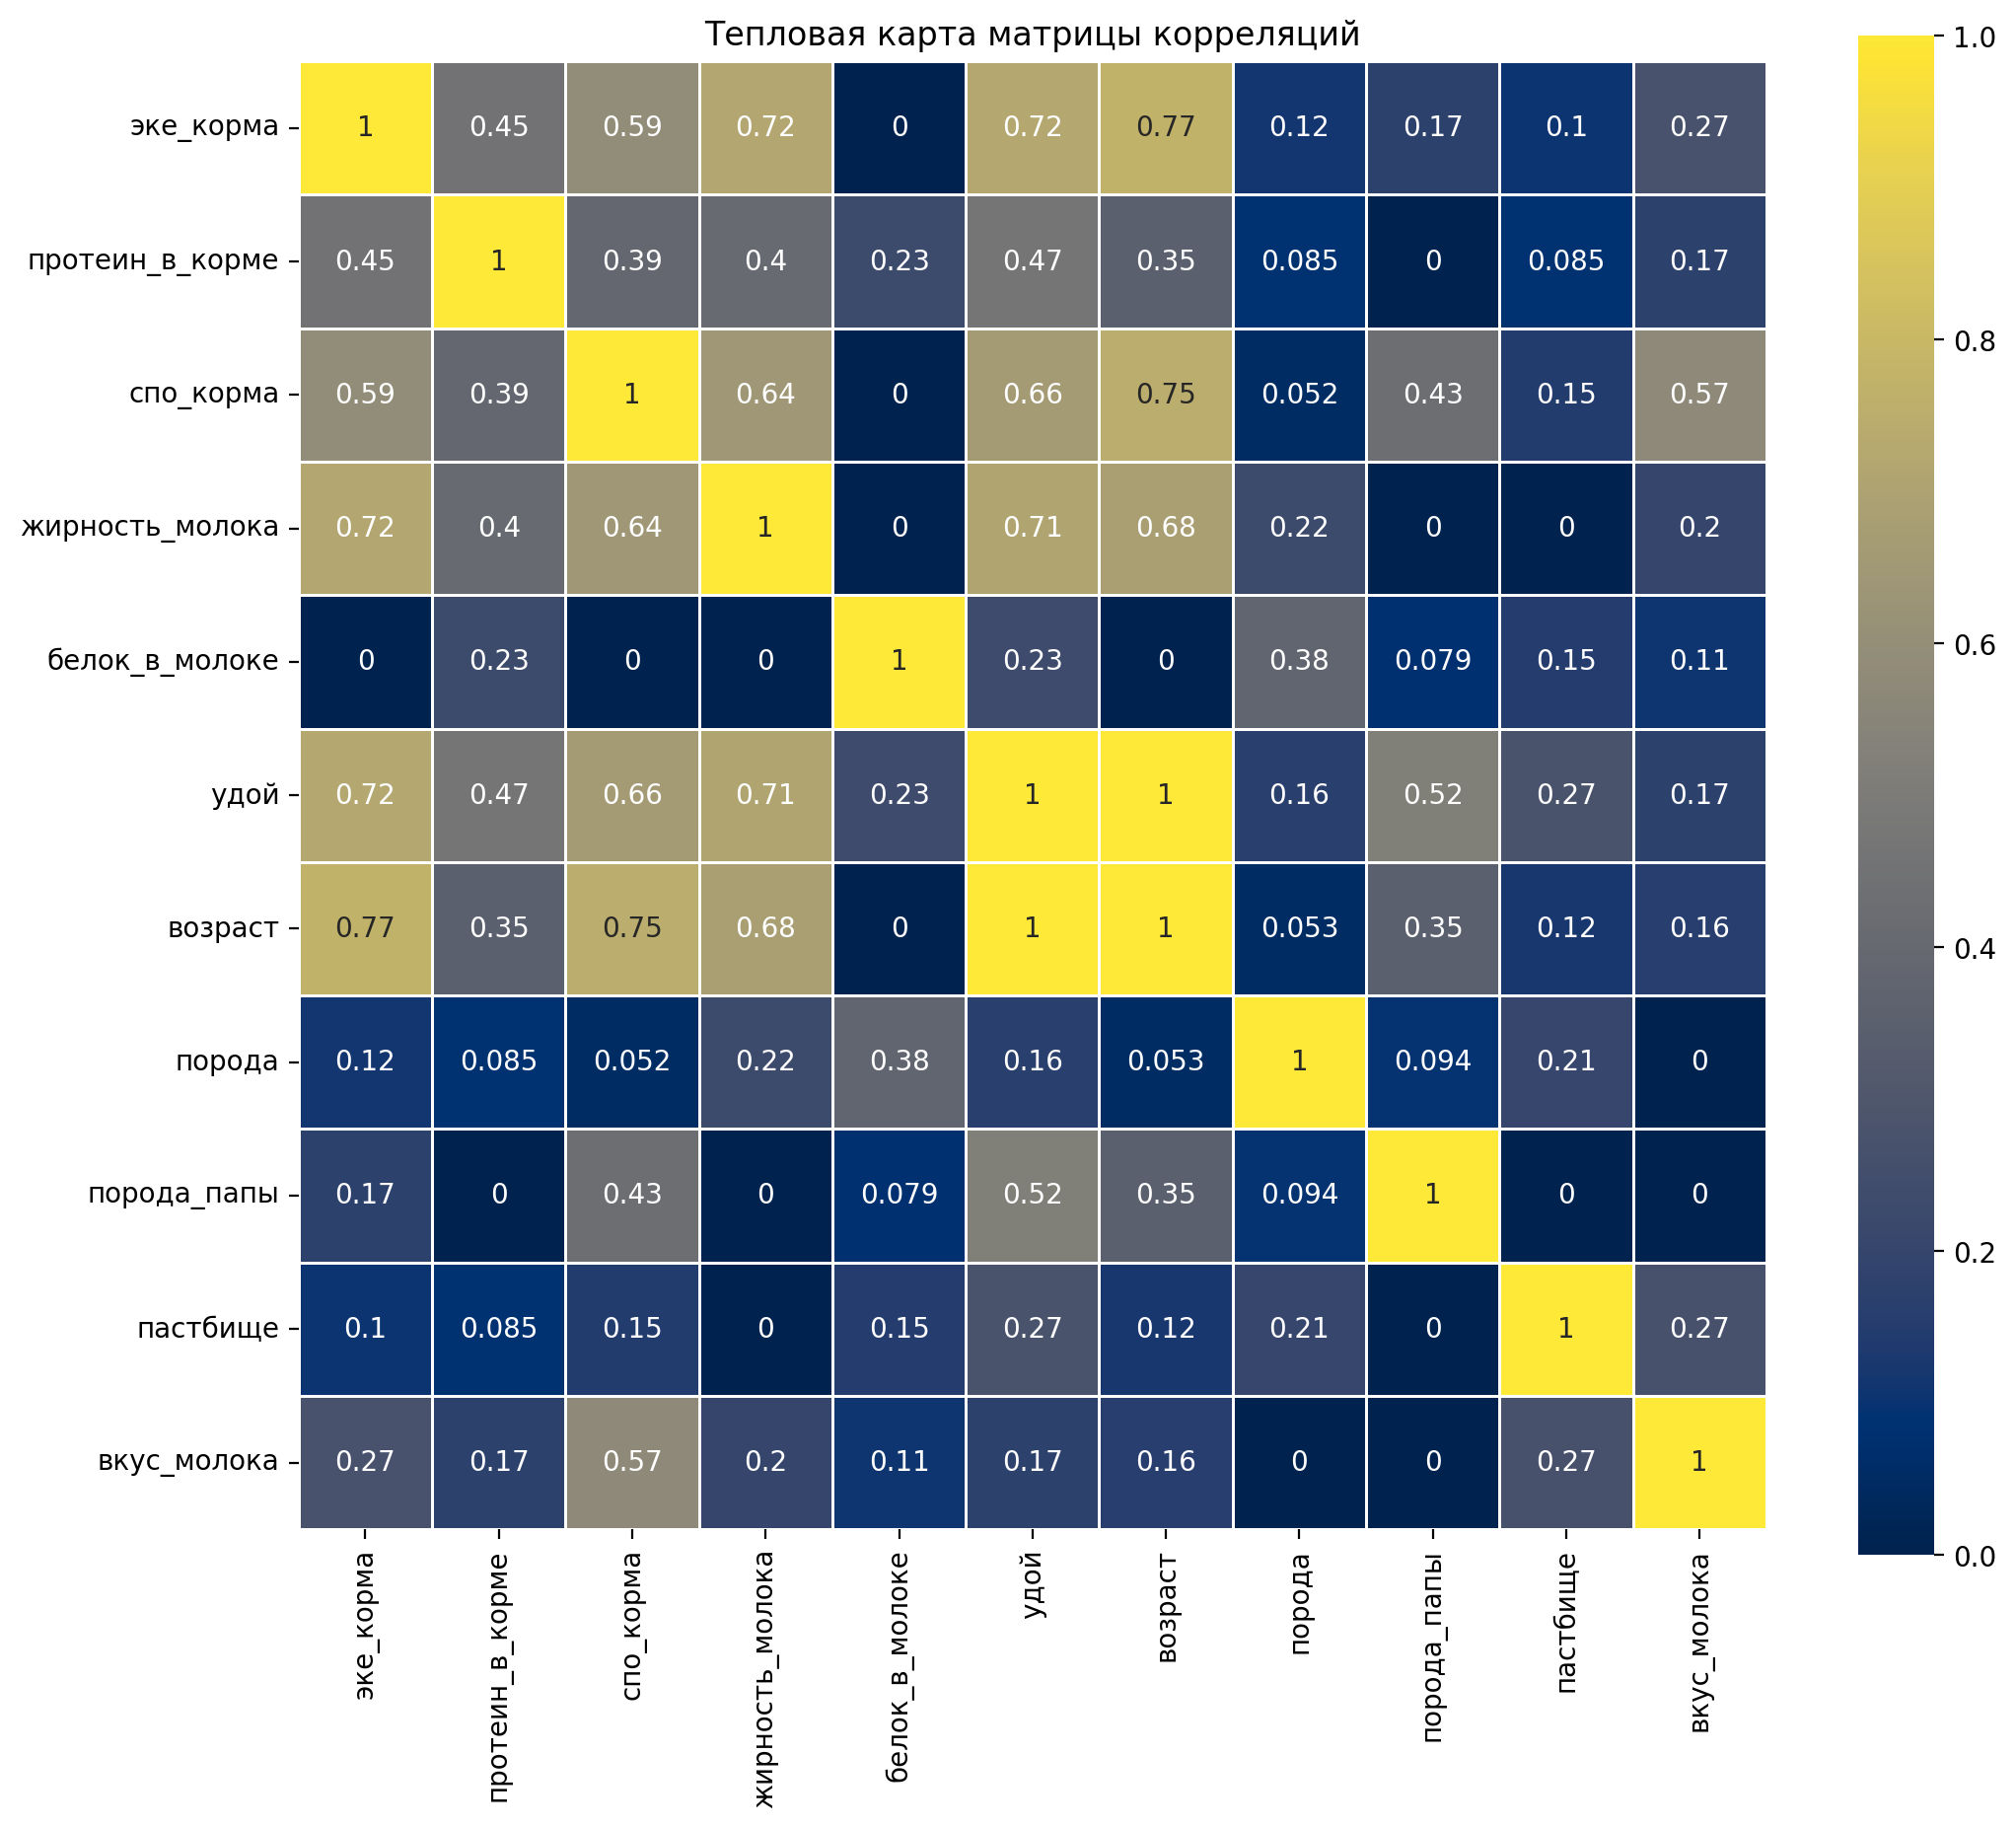

In [86]:
num_col_names = ['эке_корма', 'протеин_в_корме', 'спо_корма', 'жирность_молока', 'белок_в_молоке', 'удой']
cat_col_names = ['возраст', 'порода', 'порода_папы', 'пастбище', 'вкус_молока']

corr_coefficients = ferma_main[num_col_names + cat_col_names].phik_matrix(interval_cols=num_col_names)

fig, ax = plt.subplots(1, 1, figsize=(12, 10))
sns.heatmap(corr_coefficients, annot=True, square=True, linewidths=0.5, cmap='cividis', ax=ax)
ax.set_title('Тепловая карта матрицы корреляций')
pass

На тепловой карте матрицы корреляций видно, что:
- Целевой признак `удой` имеет весьма высокую связь с признаком `возраст`, высокую связь с `эке_корма` и `жирность_молока`, заметную связь с `спо_корма` и `порода_папы`, а также умеренную связь с `протеин_в_корме`.
- Целевой признак `вкус_молока` имеет заметную связь с признаками `спо_корма`.
- Мультиколлинеарности, которая может негативно повлиять на качество модели линейной регрессии, не наблюдается (нет корреляции входных признаков с коэффициентами 0.9 и выше).

### Диаграммы рассеяния количественных признаков

Построим диаграммы рассеяния всех количественных признаков в датафрейме `ferma_main`.

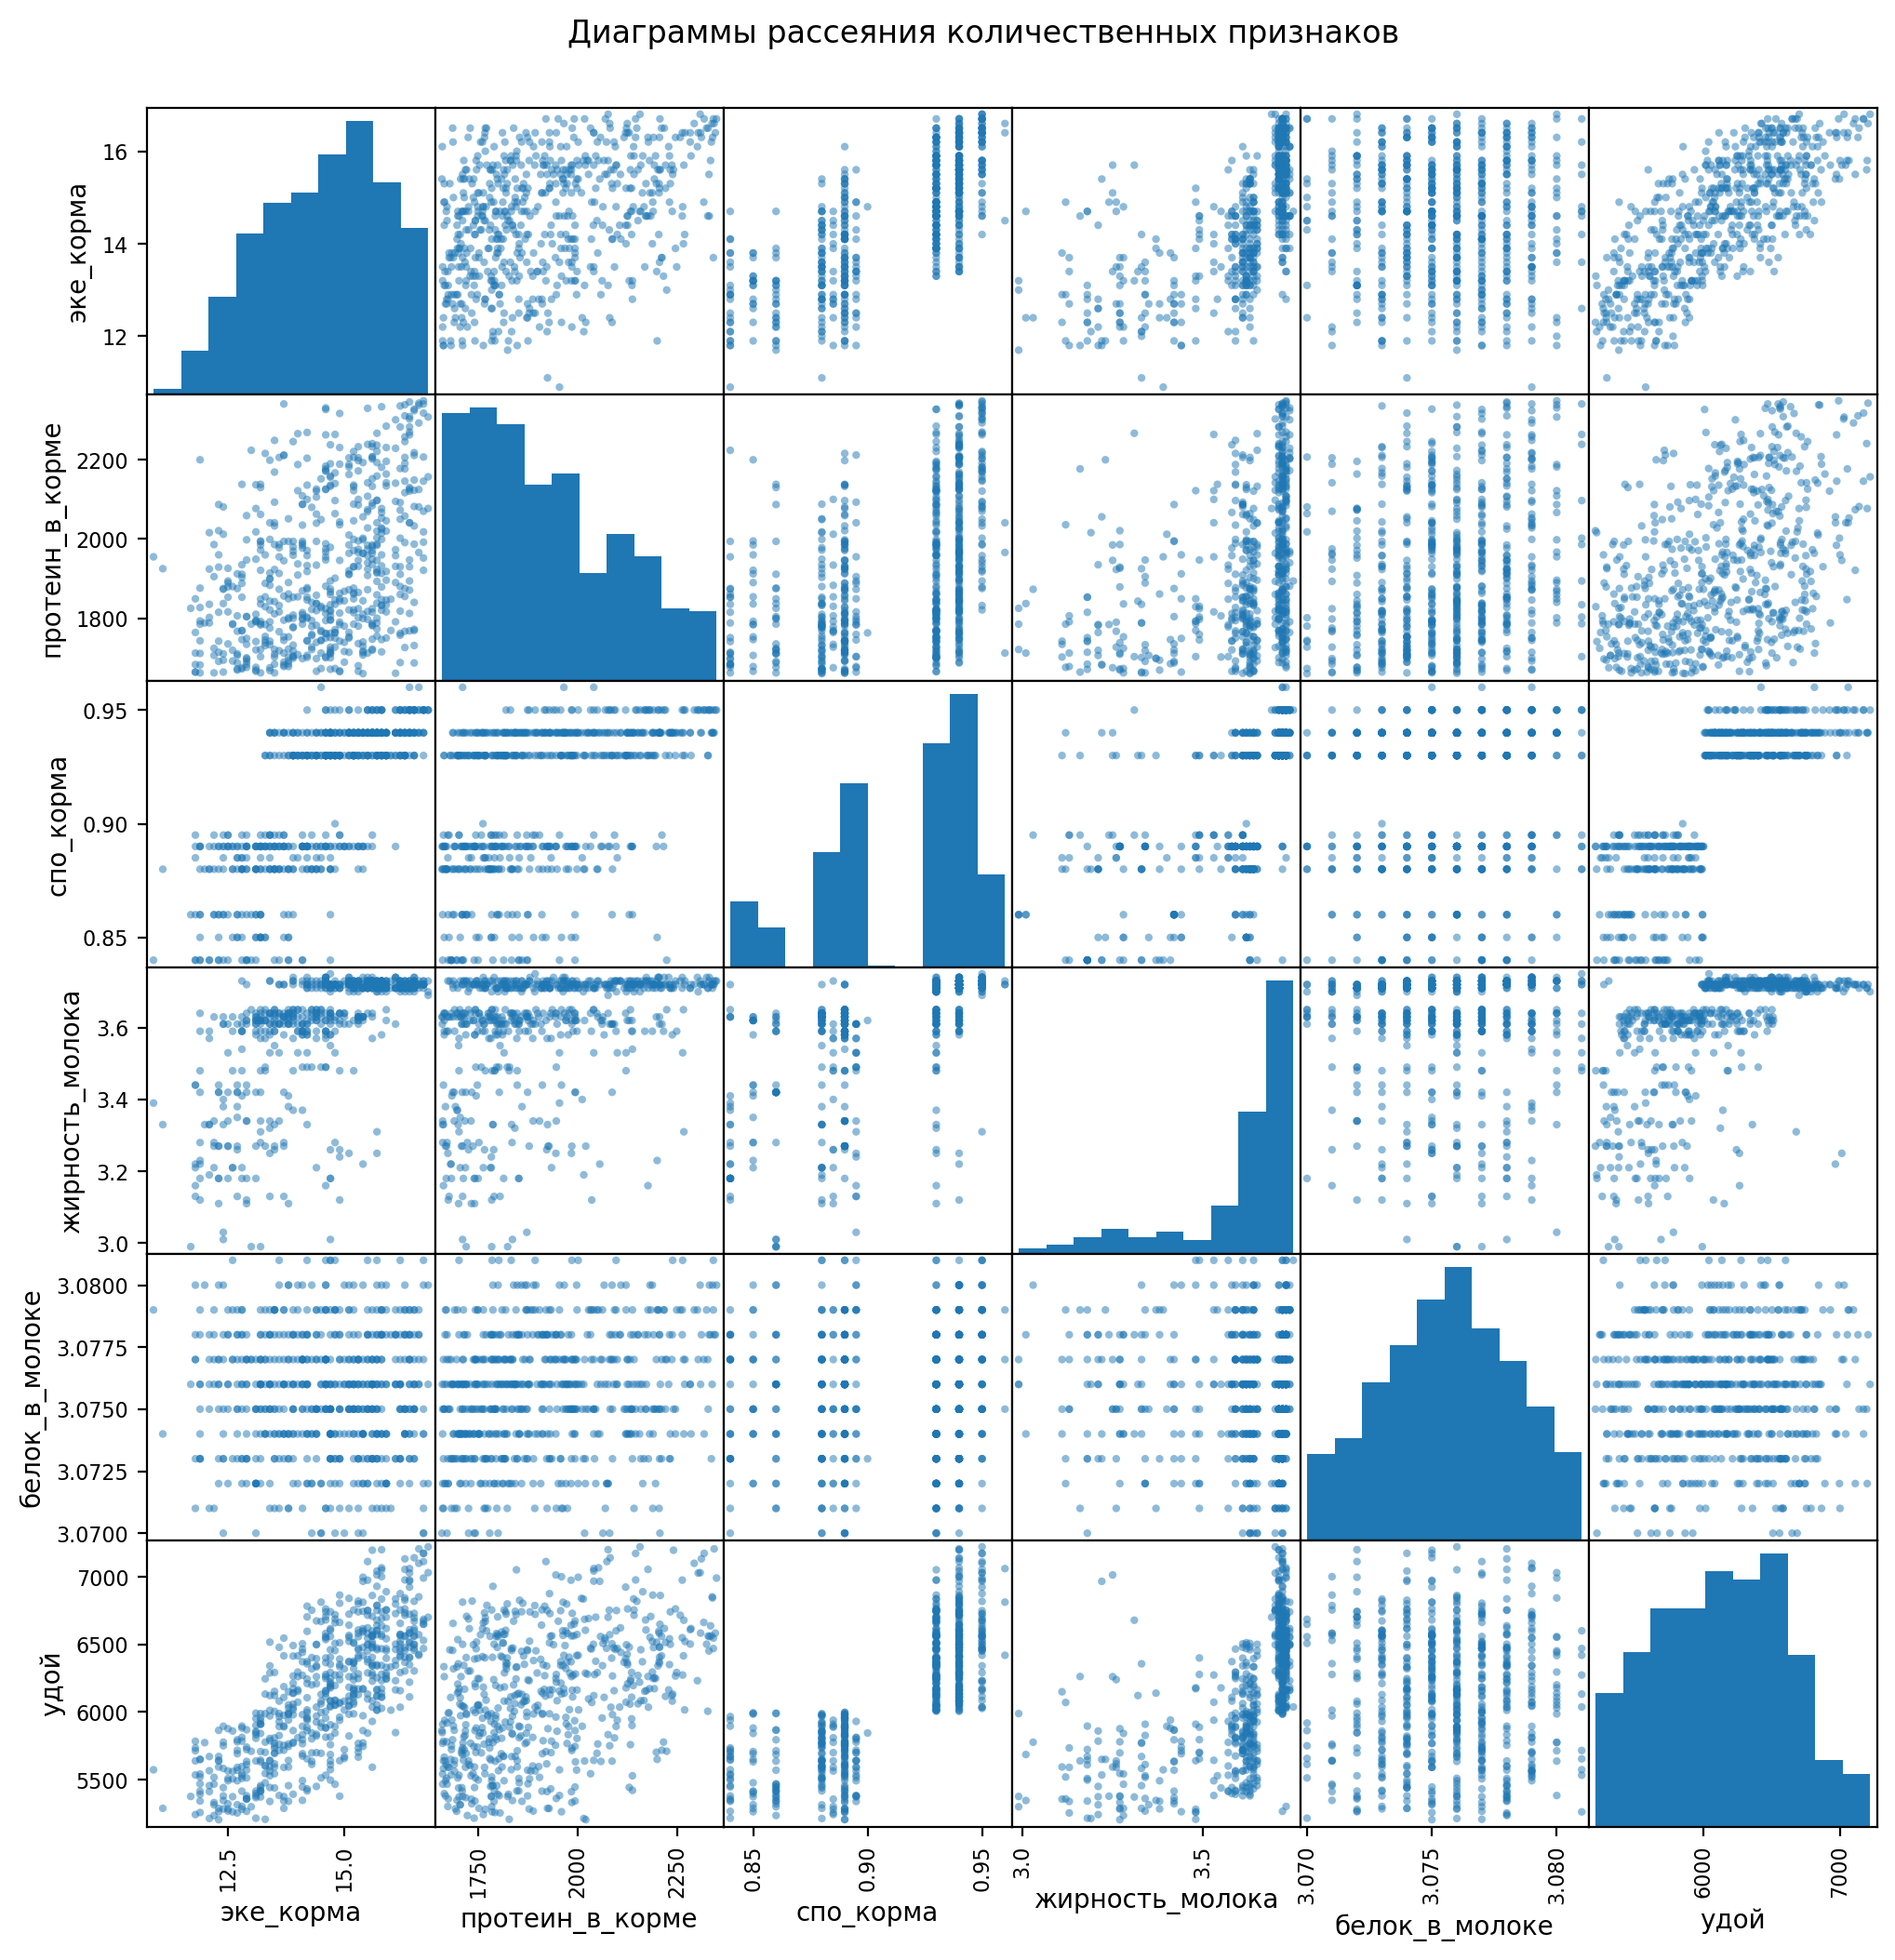

In [90]:
pd.plotting.scatter_matrix(ferma_main[num_col_names], alpha=0.5, figsize=(12, 12))
plt.suptitle('Диаграммы рассеяния количественных признаков', y=0.92)
pass

Рассмотрим связи количественных признаков с целевым признаком `удой` детальнее.

#### Показатель питательности корма

Посмотрим на диаграммы целевого признака `удой` и признака `эке_корма`.

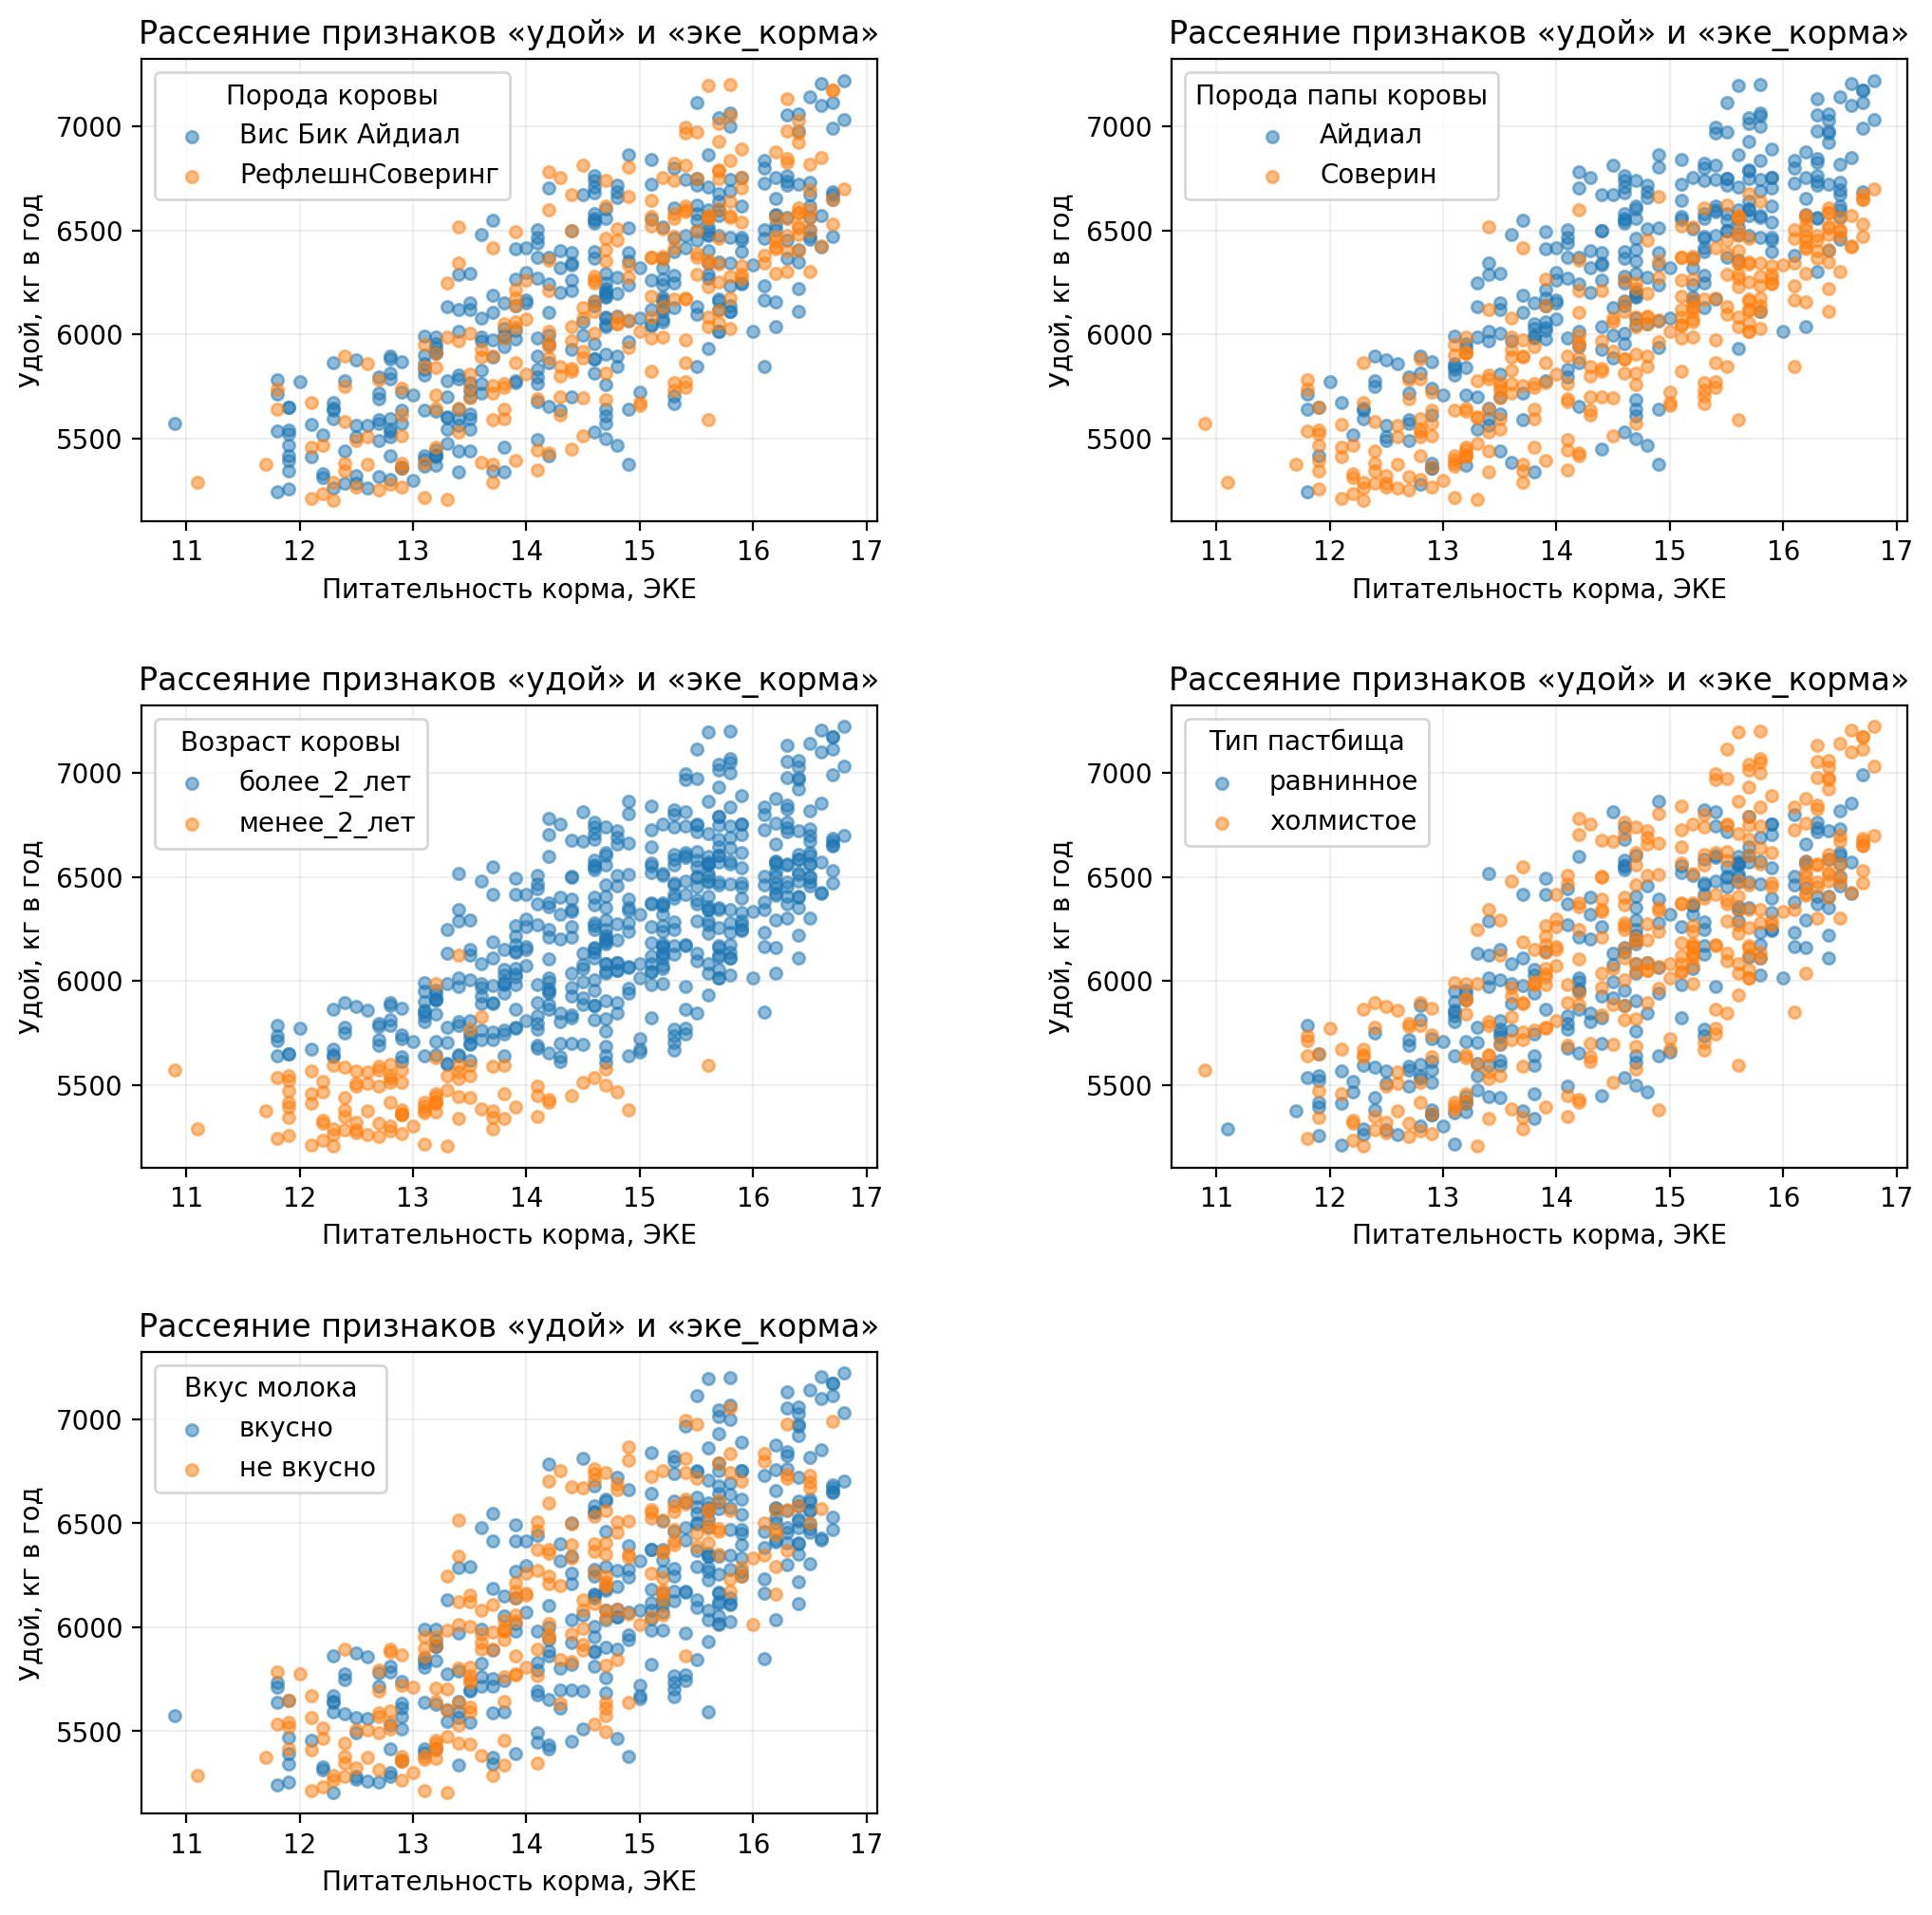

In [94]:
group_col_names = ['порода', 'порода_папы', 'возраст', 'пастбище', 'вкус_молока']
display_scatters(ferma_main, 'эке_корма', 'удой', group_col_names, ferma_main_features)

На диаграммах рассеяния заметно, что связь удоя и показателя питательности корма нелинейная — при этом нелинейность можно убрать, если возвести `эке_корма` в квадрат.

Связи удоя и показателя питательности корма сильно отличаются в погдруппах:
- по породе папе коровы (у коров от пап породы Айдиал увеличение питательности корма дает больший прирост удоя, чем у коров от пап породы Соверин);
- по возрасту коровы (увеличение питательности корма для коров не влияет на удой).

#### Содержание сырого протеина в корме

Посмотрим на диаграммы целевого признака `удой` и признака `протеин_в_корме`.

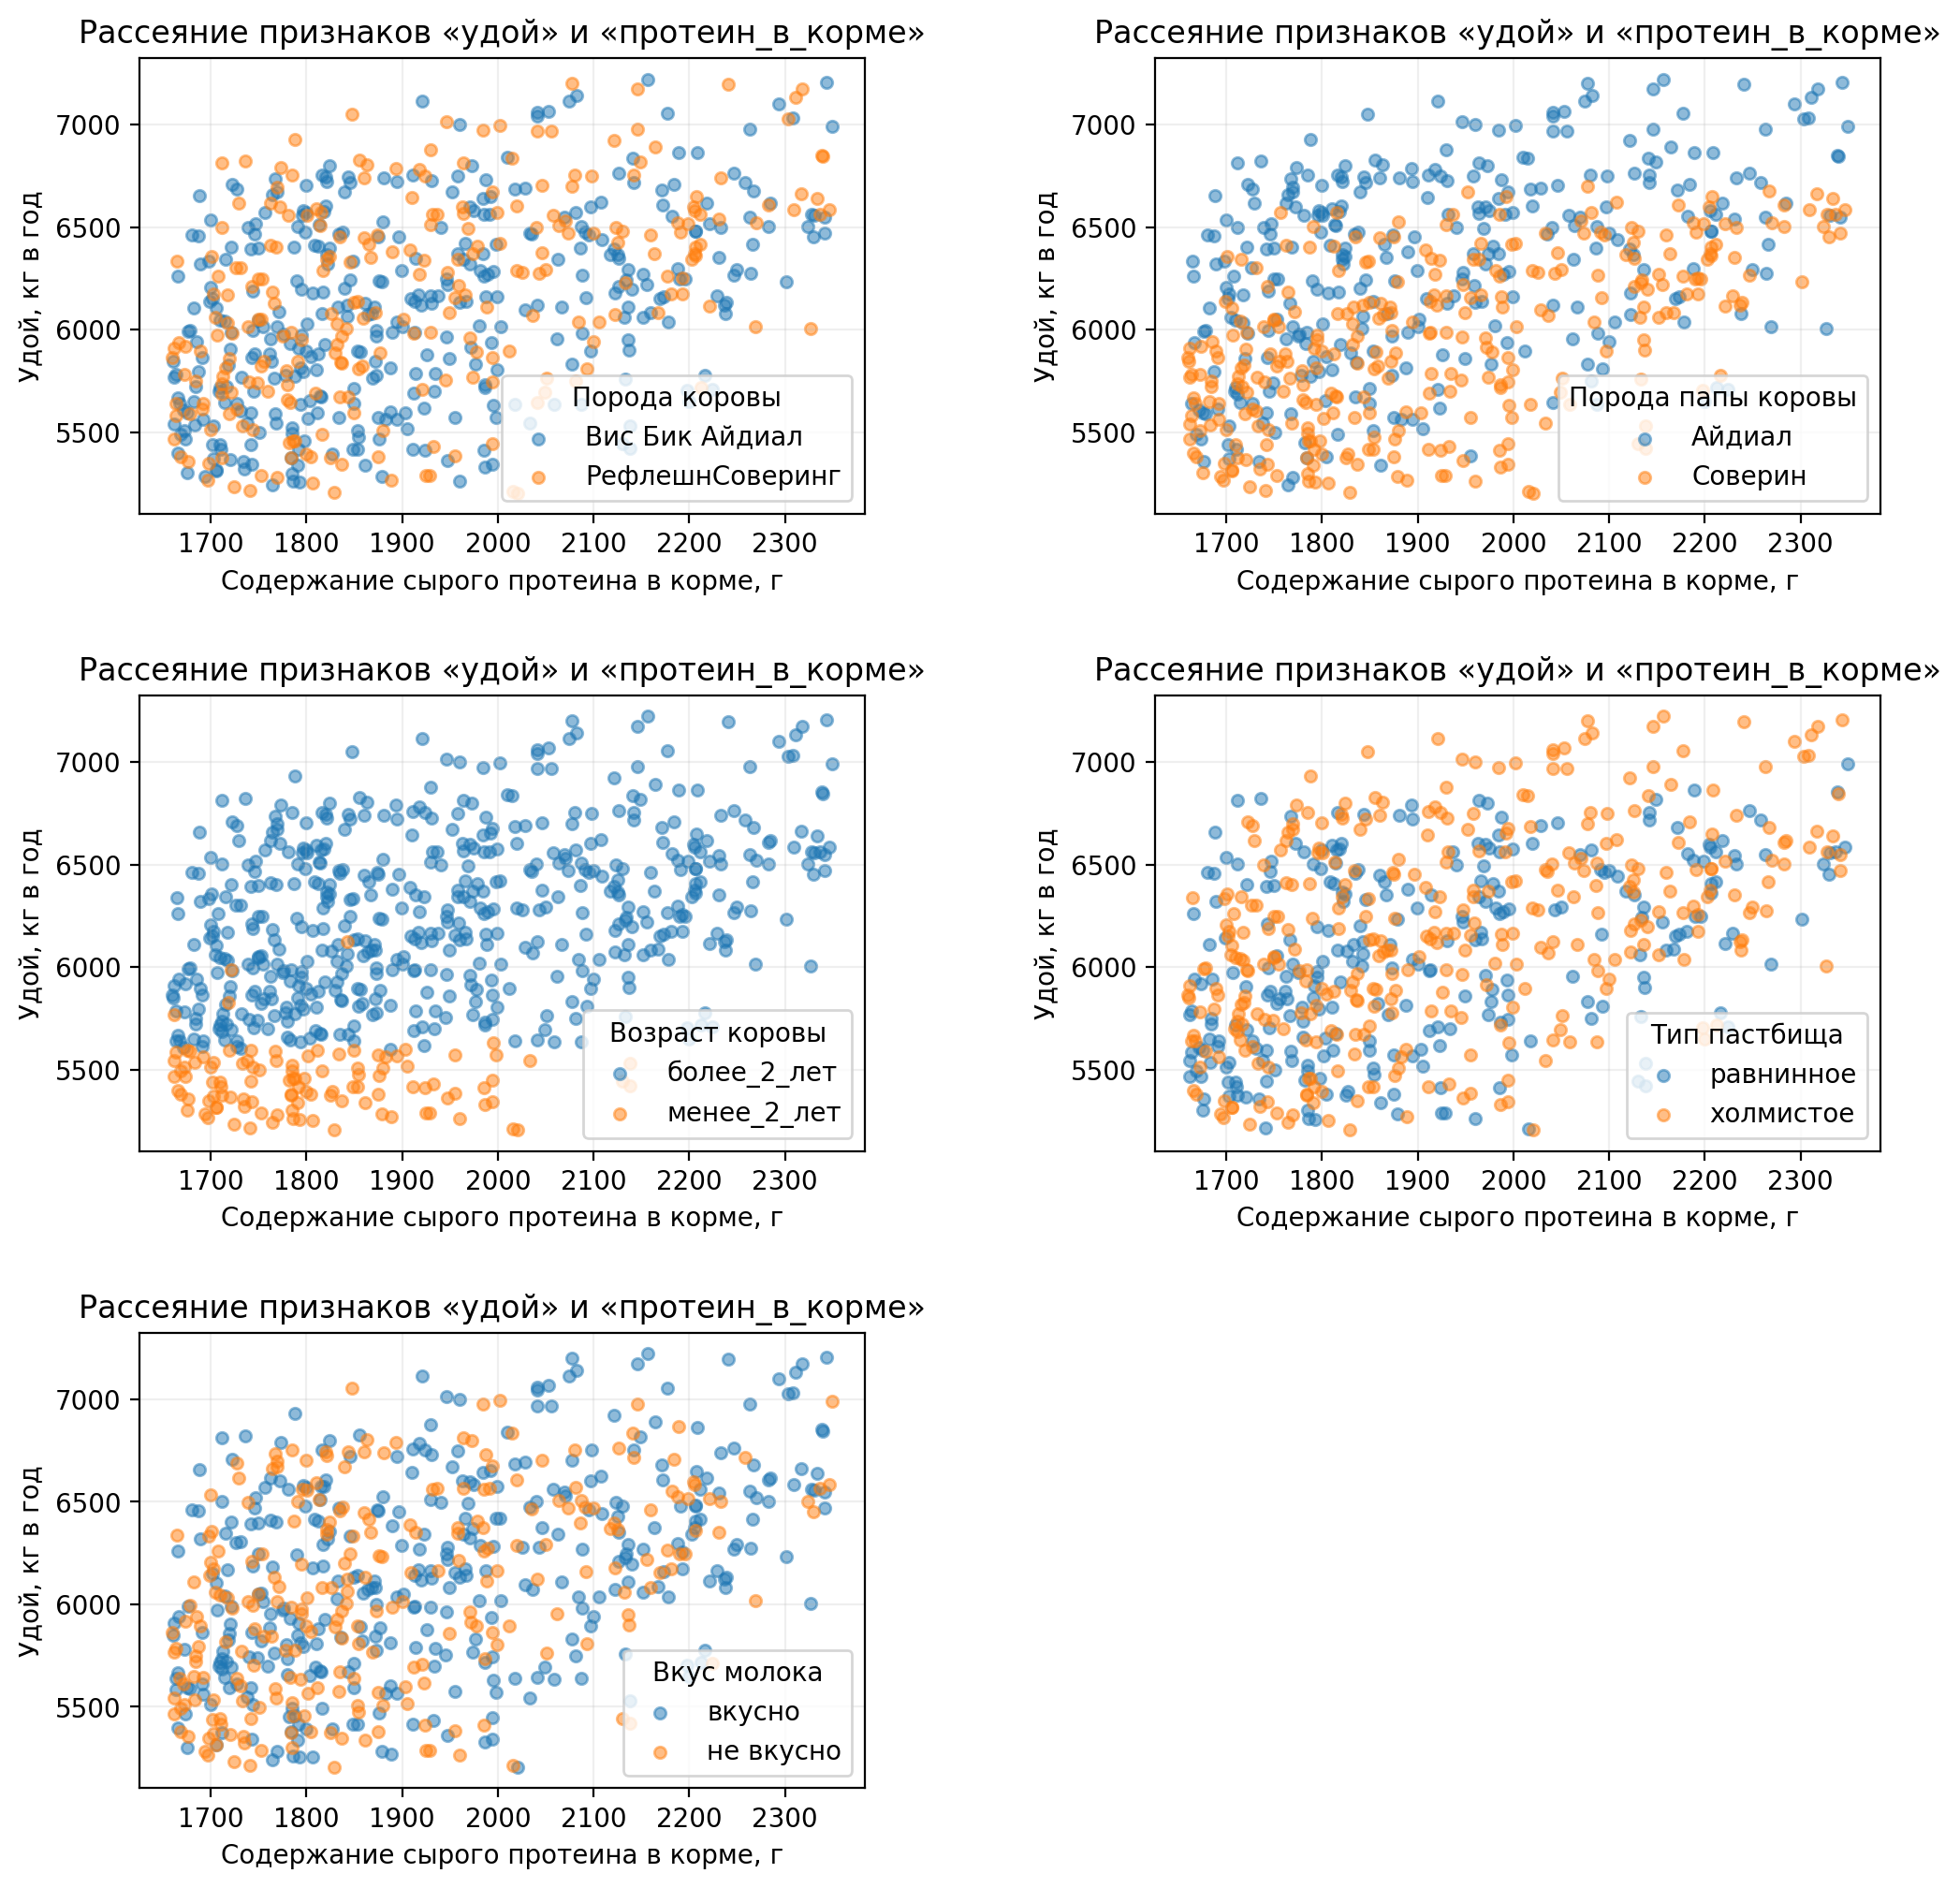

In [98]:
display_scatters(ferma_main, 'протеин_в_корме', 'удой', group_col_names, ferma_main_features)

Связи удоя и содержания сырого протеина в корме сильно отличаются в погдруппах:
- по породе папе коровы (у коров от пап породы Айдиал увеличение содержания сырого протеина в корме дает больший прирост удоя, чем у коров от пап породы Соверин);
- по возрасту коровы (содержание сырого протеина в корме не влияет на удой).

#### Сахаро-протеиновое соотношение в корме

Посмотрим на диаграммы целевого признака `удой` и признака `спо_корма`.

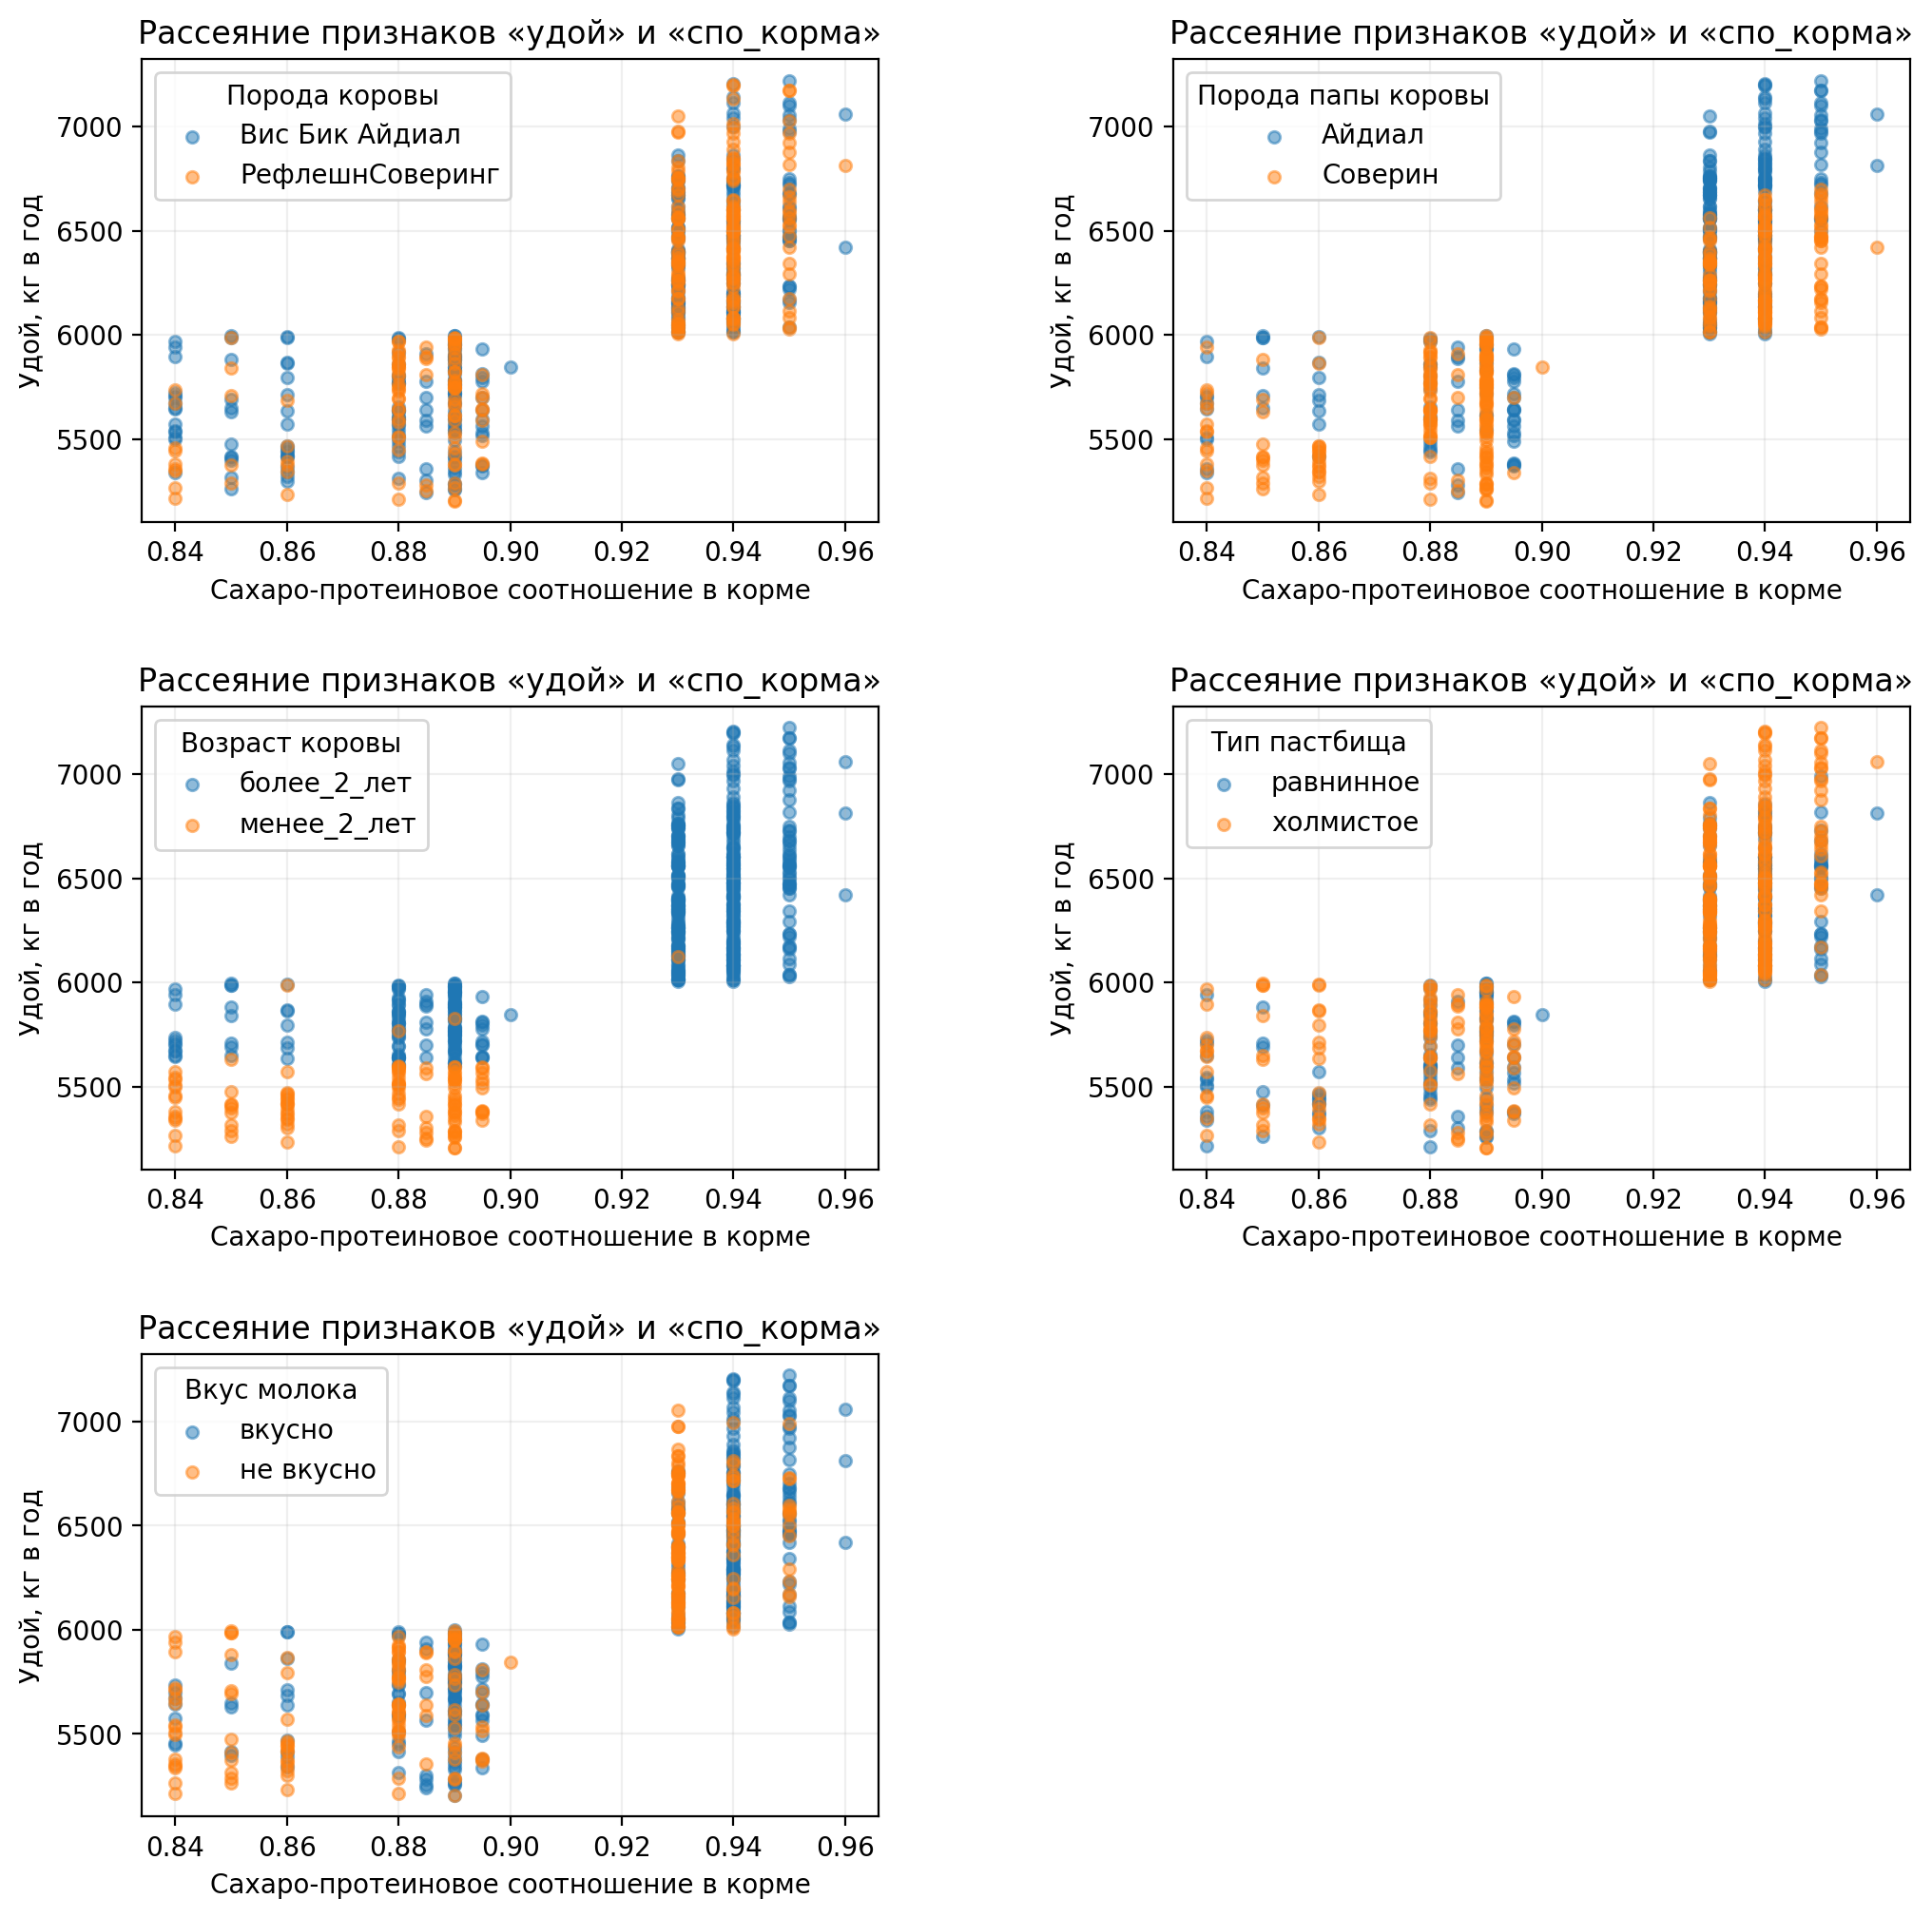

In [102]:
display_scatters(ferma_main, 'спо_корма', 'удой', group_col_names, ferma_main_features)

На диаграммах рассеяния заметно, что данные раделены на два кластера — кластер `спо_корма < 0.92` с удоем до 6000 кг молока в год и кластер `спо_корма > 0.92` с удоем от 6000 кг молока в год. Можно ввести новый категориальный признак, отвечающий за эти кластеры.

#### Содержание жиров в молоке

Посмотрим на диаграммы целевого признака `удой` и признака `жирность_молока`.

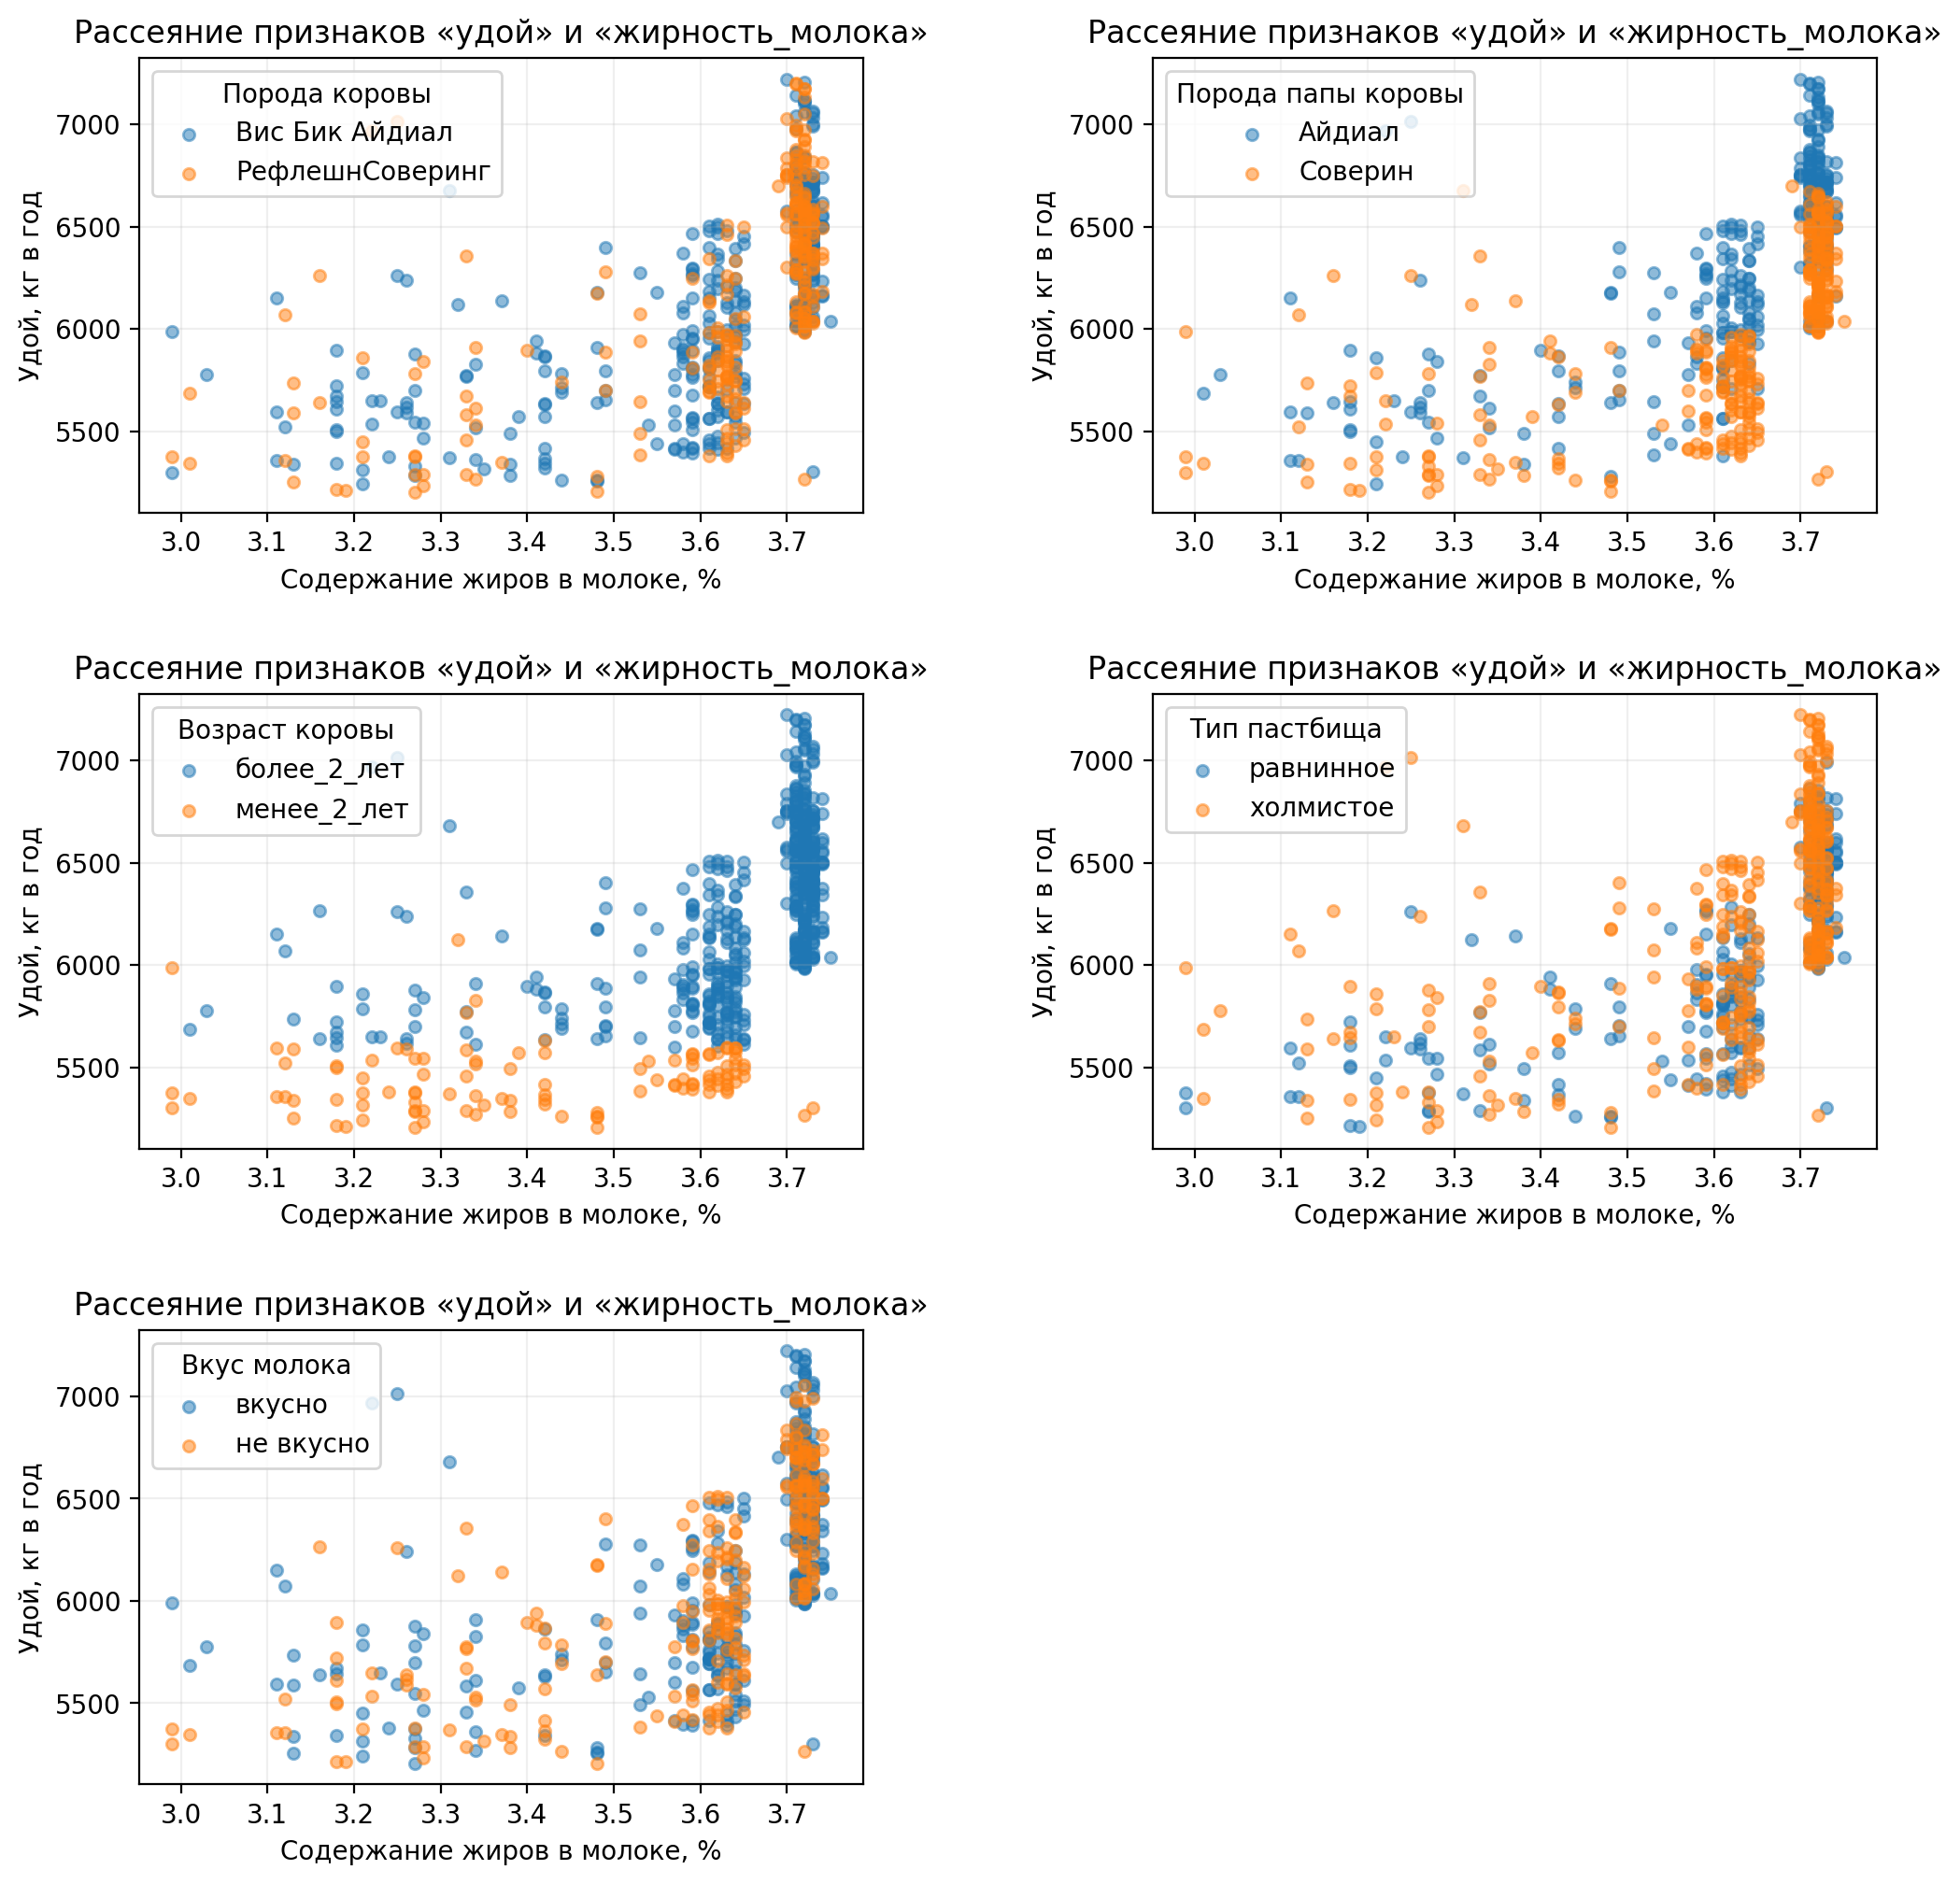

In [106]:
display_scatters(ferma_main, 'жирность_молока', 'удой', group_col_names, ferma_main_features)

На диаграммах рассеяния заметно, что данные раделены на несколько кластеров — особенно выделяется кластер с `жирность_молока >= 3.7` с удоем от 6000 кг молока в год. Можно ввести новый категориальный признак, отвечающий за эти кластеры.

Связи удоя и содержание жиров в молоке сильно отличаются в погдруппах:
- по породе папе коровы (у коров от пап породы Айдиал высоким значениям жирности молока соответствует больший удой, чем у , чем у коров от пап породы Соверин);
- по возрасту коровы (содержание жиров в молоке не коррелирует с удоем).

#### Содержание белков в молоке

Посмотрим на диаграммы целевого признака `удой` и признака `белок_в_молоке`.

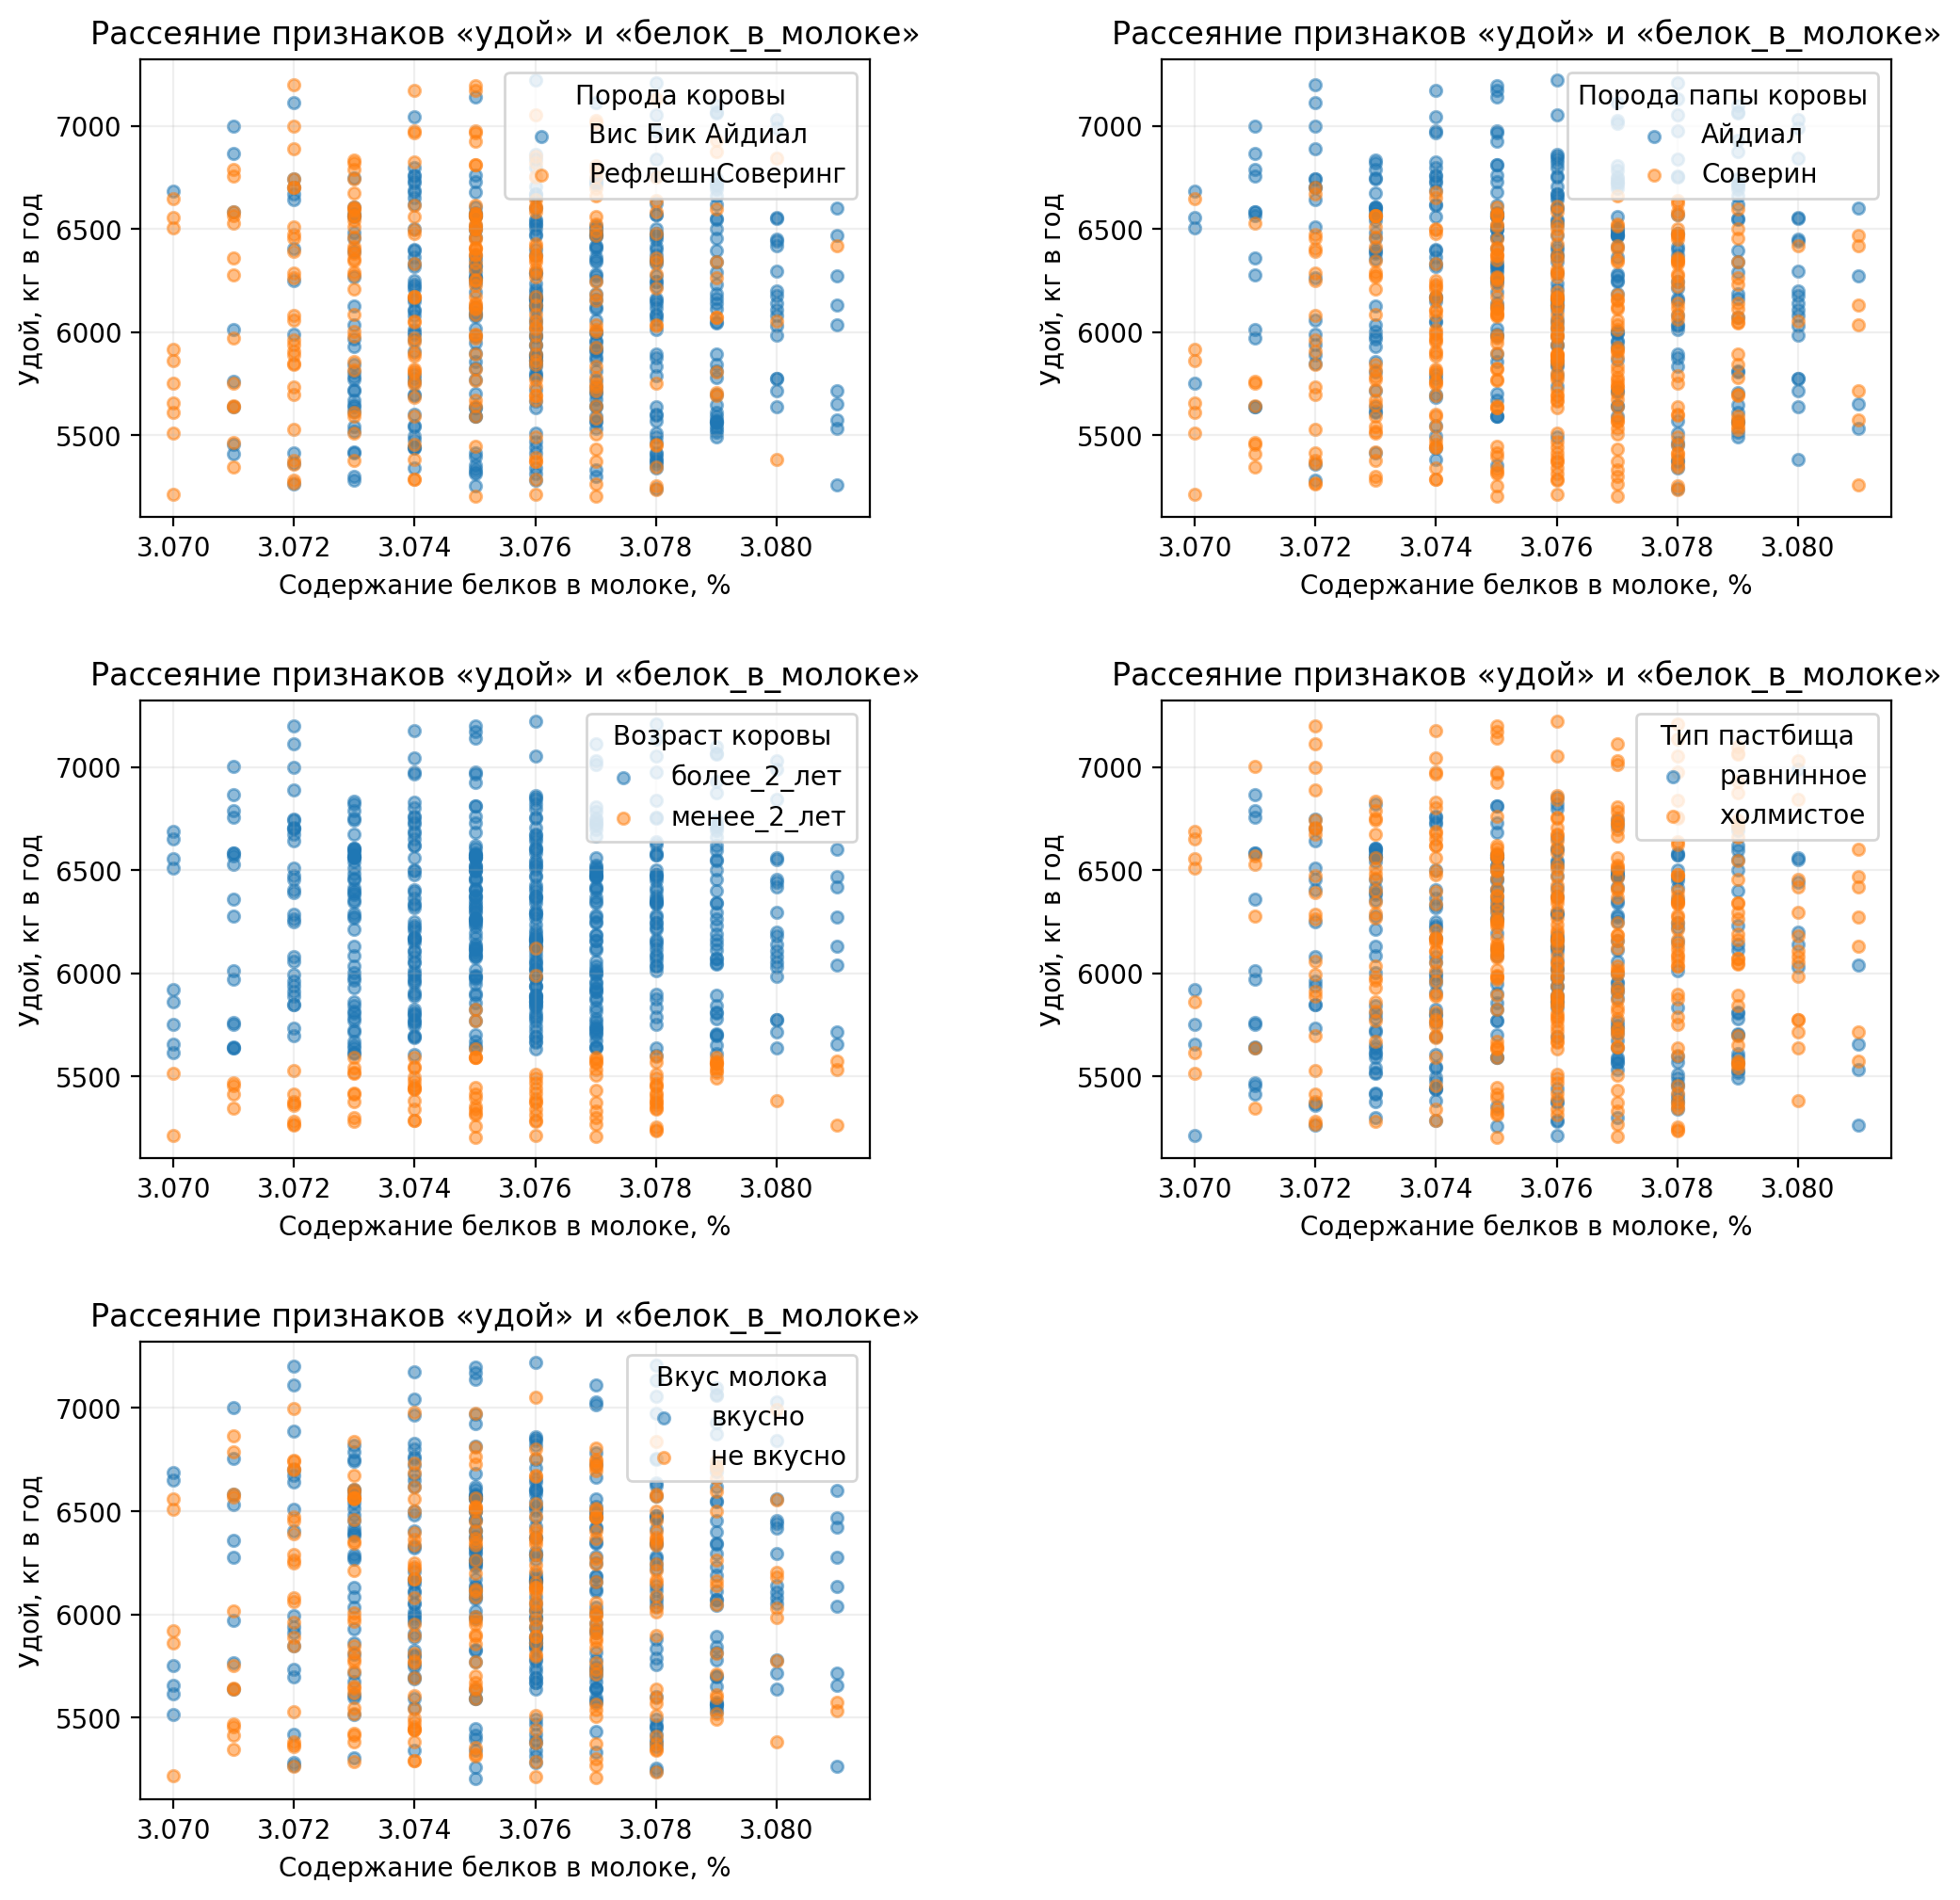

In [110]:
display_scatters(ferma_main, 'белок_в_молоке', 'удой', group_col_names, ferma_main_features)

### Влияние категориальных признаков на вкус молока

Посмотрим на процент коров, дающих вкусное молоко, в различных подгруппах.

In [113]:
modified_data = ferma_main.copy()
modified_data['вкусное_молоко'] = modified_data['вкус_молока'].apply(lambda x: True if x == 'вкусно' else False)
for cat_col_name in ['возраст', 'порода', 'порода_папы', 'пастбище']:
    display(modified_data.pivot_table(index=cat_col_name, values='вкусное_молоко', 
                                      aggfunc=lambda x: f'{x.mean() * 100:.2f}%'))

вкусное_молоко
возраст                   
более_2_лет         61.28%
менее_2_лет         46.79%

вкусное_молоко
порода                        
Вис Бик Айдиал          58.42%
РефлешнСоверинг         59.22%

вкусное_молоко
порода_папы               
Айдиал              58.60%
Соверин             58.90%

вкусное_молоко
пастбище                
равнинное         48.73%
холмистое         66.67%

Коровы в возрасте более 2 лет чаще дают вкусное молоко, чем молодые коровы. Также вкус молока заметно различается в подгруппах по пастбищу: коровы, пасущиеся в холмистой местности, чаще дают вкусное молоко, чем коровы, пасущиеся на равнинах.

### Результаты корреляционного анализа

В результате корреляционного анализа можно сделать несколько выводов:
- Целевой признак `удой` имеет весьма высокую связь с возрастом, высокую связь с показателем питательности корма коровы и с содержанием жиров в молоке, заметную связь с сахаро-протеиновым соотношением в корме и породой папы, а также умеренную связь с содержанием сырого протеина в корме.
- Взаимосвязи целевого признака `удой` и количественных характеристик корма и молока нелинейные. При этом от ряда нелинейных связей можно избавиться:
    - ввести новый количественный признак, возведя показатель питательности корма коровы `эке_корма` в квадрат;
    - ввести новый категориальный признак, разделив данные на категории по уровню сахаро-протеиновое соотношения `спо_корма` (менее 0.92 и более 0.92).
- Взаимосвязи целевого признака `удой` и количественных характеристик корма и молока сильно различаются в подгруппах по породе папы коровы и по возрасту коровы (коровы до 2 лет дают мало молока независимо от других признаков).
- Наибольшая корреляция целевого признака `вкус_молока` наблюдается с сахаро-протеиновым соотношением в корме, при этом на вкус влияют и другие характеристики корма и молока, а также вораст коровы и тип пастбища.

## Обучение моделей линейной регрессии

Обучим несколько моделей простой линейной регрессии, сравним их качество — и с помощью лучшей модели спрогнозируем удой коров, которых фермер хочет купить.

### Модель 1

Обучим первую модель линейной регрессии на исходных признаках из данных о стаде фермера. На удой могут влиять как характеристики корма и тип пастбища, так и «генетика» коровы. Поскольку фермер собирается изменить корм коров «ЭкоФермы», которых он собирается купить, следовательно, изменятся и характеристики их молока. Значит, на признаки `жирность_молока` и `белок_в_молоке` при обучении модели мы опираться не можем.

Таким образом обучим первую модель линейной регрессии на следующих признаках:
- количественные: `эке_корма`, `протеин_в_корме`, `спо_корма`.
- категориальные: `возраст`, `порода`, `порода_папы`, `пастбище`.

Для этого разобьем данные из датафрейма `ferma_main` на тренировочную и тестовую выборки. Перед обучением отасштабируем количественные признаки с помощью `StandardScaler` и кодируем категориальные признаки с помощью `OneHotEncoder`.

In [121]:
class ModelLinearRegression:

    def __init__(self, num_col_names, cat_col_names):
        self.num_col_names = num_col_names
        self.cat_col_names = cat_col_names
        self.scaler = StandardScaler() # MinMaxScaler()
        self.encoder = OneHotEncoder(drop='first', sparse_output=False)
        self.model_lr = LinearRegression()

    def __preprocessing(self, X):
        X_scaled = self.scaler.transform(X[self.num_col_names])
        X_scaled = pd.DataFrame(X_scaled, columns=self.num_col_names)
        X_ohe = self.encoder.transform(X[self.cat_col_names])
        X_ohe = pd.DataFrame(X_ohe, columns=self.encoder.get_feature_names_out())
        return pd.concat([X_scaled, X_ohe], axis=1)

    def fit(self, X, y_true):
        self.scaler = self.scaler.fit(X[self.num_col_names])
        self.encoder = self.encoder.fit(X[self.cat_col_names])
        X = self.__preprocessing(X)
        self.model_lr.fit(X, y_true)

    def predict(self, X):
        X = self.__preprocessing(X)
        return self.model_lr.predict(X)

    def display_residuals(y_true, y_pred, label, color):
        residuals = y_true - y_pred
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))
        plt.subplots_adjust(wspace=0.2)
        axes[0].hist(residuals, edgecolor='white', linewidth=0.5, color=color)
        axes[0].set_title('Гистограмма распределения остатков')
        axes[0].set_xlabel('Остатки')
        axes[0].set_ylabel('Частота')
        axes[1].scatter(x=y_pred, y=residuals, color=color)
        axes[1].set_title('Анализ дисперсии')
        axes[1].set_xlabel('Предсказания модели — ' + label)
        axes[1].set_ylabel('Остатки')
        axes[1].grid(alpha=0.5, dashes=(2, 2))

    def get_metrics(y_true, y_pred):
        residuals = y_true - y_pred
        interval95 = st.norm.interval(confidence=0.95, loc=residuals.mean(), scale=residuals.std())
        mse = mean_squared_error(y_true, y_pred)
        rmse = mean_squared_error(y_true, y_pred) ** 0.5
        mae = mean_absolute_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)
        return {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R²': r2, 
                'mean': residuals.mean(), '95% интервал остатков': interval95}

In [122]:
# разобьем данные на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(ferma_main.drop('удой', axis=1), 
                                                    ferma_main['удой'], random_state=RANDOM_STATE)

# количественные признаки и категориальные признаки
num_col_names = ['эке_корма', 'протеин_в_корме', 'спо_корма']
cat_col_names = ['возраст', 'порода', 'порода_папы', 'пастбище']

# обучение модели на тренировочной выборке
model_1 = ModelLinearRegression(num_col_names, cat_col_names)
model_1.fit(X_train, y_train)

# предсказания на тестовой выборке
predictions = model_1.predict(X_test)

Проанализируем распределение остатков.

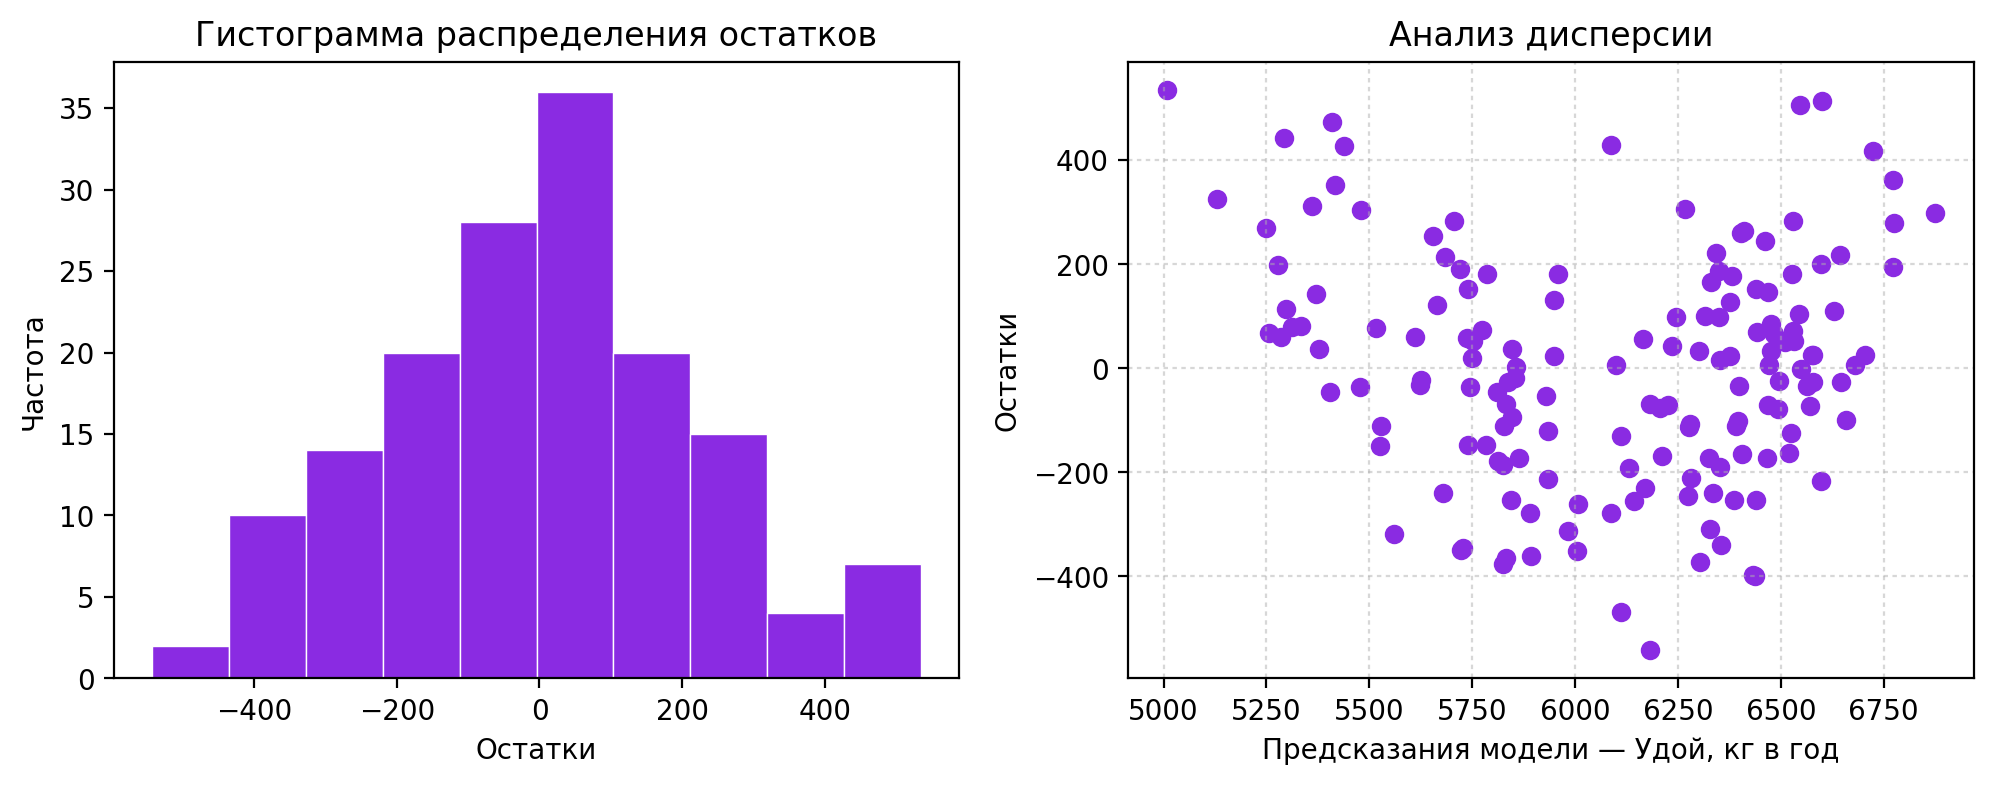

In [124]:
ModelLinearRegression.display_residuals(y_test, predictions, ferma_main_features['удой'], 'blueviolet')

Остатки имеют нормальное распределение со средним значением около 0. Однако на диаграмме рассеяния мы видим «дугу», значит, какие-то признаки нелинейно связаны с целевым. Модель надо улучшать: изменить взаимосвязь входных признаков с целевым, добавить в модель дополнительные признаки.

Посмотрим на основные метрики для оценки качества регрессионной модели.

In [127]:
metrics = dict() 
metrics['Модель 1'] = ModelLinearRegression.get_metrics(y_test, predictions)
metrics['Модель 1']

{'MSE': 47499.999455259865,
 'RMSE': 217.9449459273141,
 'MAE': 173.80122314737417,
 'R²': 0.7832029531509055,
 'mean': 1.6617550037306104,
 '95% интервал остатков': (-426.86576659989214, 430.18927660735335)}

Средняя абсолютная ошибка MAE показывает, что предсказание удоя в среднем отличается от истинного значения на ~174 кг молока в год. Коэффициент детерминации R² показывает, что предсказание модели точнее, чем среднее значение целевого признака в ~78% случаев.

### Модель 2

Добавим в модель дополнительные признаки, необходимые для исключения ряда нелинейных связей между входными и целевым параметром `удой`: показатель питательности корма коровы в квадрате и категорию сахаро-протеиновое соотношения.

In [131]:
def first_modify_data(data):
    data['эке_корма_квадрат'] = data['эке_корма'] ** 2
    data['спо_корма_категория'] = data['спо_корма'].apply(lambda x: 'высокое' if x >= 0.92 else 'низкое')


first_modify_data(ferma_main)

Обучим вторую модель линейной регрессии на следующих признаках:
- количественные: `эке_корма_квадрат`, `протеин_в_корме`.
- категориальные: `возраст`, `порода`, `порода_папы`, `пастбище`, `спо_корма_категория`.

In [133]:
# разобьем данные на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(ferma_main.drop('удой', axis=1), 
                                                    ferma_main['удой'], random_state=RANDOM_STATE)

# количественные признаки и категориальные признаки
num_col_names = ['эке_корма_квадрат', 'протеин_в_корме']
cat_col_names = ['возраст', 'порода', 'порода_папы', 'пастбище', 'спо_корма_категория']

# обучение модели на тренировочной выборке
model_2 = ModelLinearRegression(num_col_names, cat_col_names)
model_2.fit(X_train, y_train)

# предсказания на тестовой выборке
predictions = model_2.predict(X_test)

Проанализируем распределение остатков.

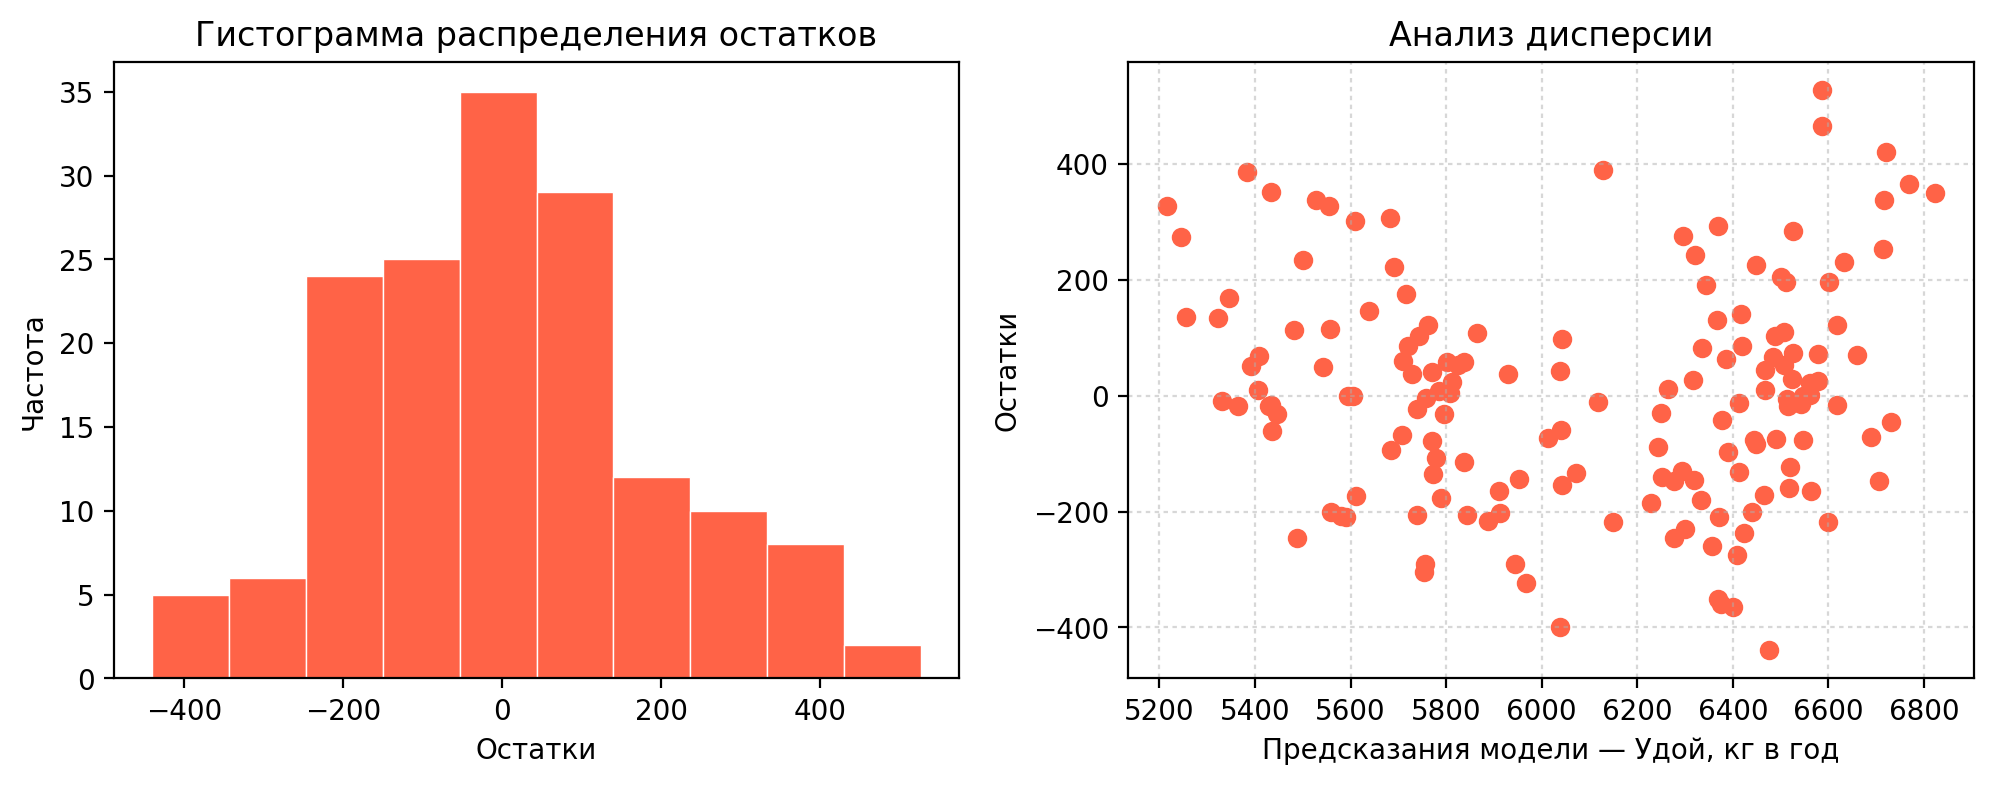

In [135]:
ModelLinearRegression.display_residuals(y_test, predictions, ferma_main_features['удой'], 'tomato')

Посмотрим на основные метрики для оценки качества регрессионной модели.

In [137]:
metrics['Модель 2'] = ModelLinearRegression.get_metrics(y_test, predictions)
metrics['Модель 2']

{'MSE': 36207.49001635704,
 'RMSE': 190.28265821234746,
 'MAE': 149.7197997704034,
 'R²': 0.8347436421181885,
 'mean': 3.7396400790563313,
 '95% интервал остатков': (-370.33637491720447, 377.8156550753172)}

Средняя абсолютная ошибка MAE уменьшилась до ~150 кг молока в год. Коэффициент детерминации R² показывает, что предсказание модели точнее, чем среднее значение целевого признака в ~83% случаев. Метрики говорят о том, что вторая модель качественнее первой. Распределение остатков немного смещено вправо — модель чуть занижает предсказания.

### Модель 3

Добавим в датафрейм с данными о стаде фермера `ferma_main` данные об имени папы коровы из датафрейма `ferma_dad`.

In [141]:
ferma_main = ferma_main.merge(ferma_dad, on='id', how='left')
ferma_main.isna().sum().sum()

0

Пропусков нет — объединение прошло успешно.

In [143]:
ferma_main.groupby('имя_папы')['порода_папы'].value_counts()

имя_папы  порода_папы
Барин     Соверин        212
          Айдиал          28
Буйный    Айдиал         212
Геркулес  Айдиал          64
Соловчик  Соверин         97
          Айдиал          10
Name: count, dtype: int64

Мы видим, что в стаде фермера есть коровы как минимум от двух Баринов и двух Соловчика разных пород. А может быть быков-тёзок еще больше — вопрос к поставщику данных.

In [145]:
cow_buy.groupby('имя_папы')['порода_папы'].value_counts()

имя_папы  порода_папы
Барин     Соверин        4
Буйный    Айдиал         5
          Соверин        3
Геркулес  Айдиал         3
          Соверин        3
Соловчик  Соверин        2
Name: count, dtype: int64

Мы видим, что в данных о коровах «ЭкоФермы», которых фермер хочет изучить перед покупкой, та же проблема — есть коровы как минимум от двух Буйных и двух Геркулесов разных пород.

То есть имя папы коровы не является уникальным идентификатором быка. Если мы обучим модель, добавив признак `имя_папы`, мы только ухудшим результаты прогноза. Например, мы хотим получить прогноз по удою коровы от папы по имени Геркулес породы Соверин, а модель обучена на данных о другом Геркулесе породы Айдиал (а Геркулеса породы Соверин в обучающих данных вообще нет). Значит, **добавлять признак** `имя_папы` **нецелесообразно**. Но, ради интереса, все-таки добавим.

Признаки `порода_папы` и `имя_папы` будет очень коррелирующими, один из них можно убрать. Обучим третью модель линейной регрессии на следующих признаках:
- количественные: `эке_корма_квадрат`, `протеин_в_корме`.
- категориальные: `возраст`, `порода`, `имя_папы`, `пастбище`, `спо_корма_категория`.

In [148]:
# разобьем данные на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(ferma_main.drop('удой', axis=1), 
                                                    ferma_main['удой'], random_state=RANDOM_STATE)

# количественные признаки и категориальные признаки
num_col_names = ['эке_корма_квадрат', 'протеин_в_корме']
cat_col_names = ['возраст', 'порода', 'имя_папы', 'пастбище', 'спо_корма_категория']

# обучение модели на тренировочной выборке
model_3 = ModelLinearRegression(num_col_names, cat_col_names)
model_3.fit(X_train, y_train)

# предсказания на тестовой выборке
predictions = model_3.predict(X_test)

Проанализируем распределение остатков.

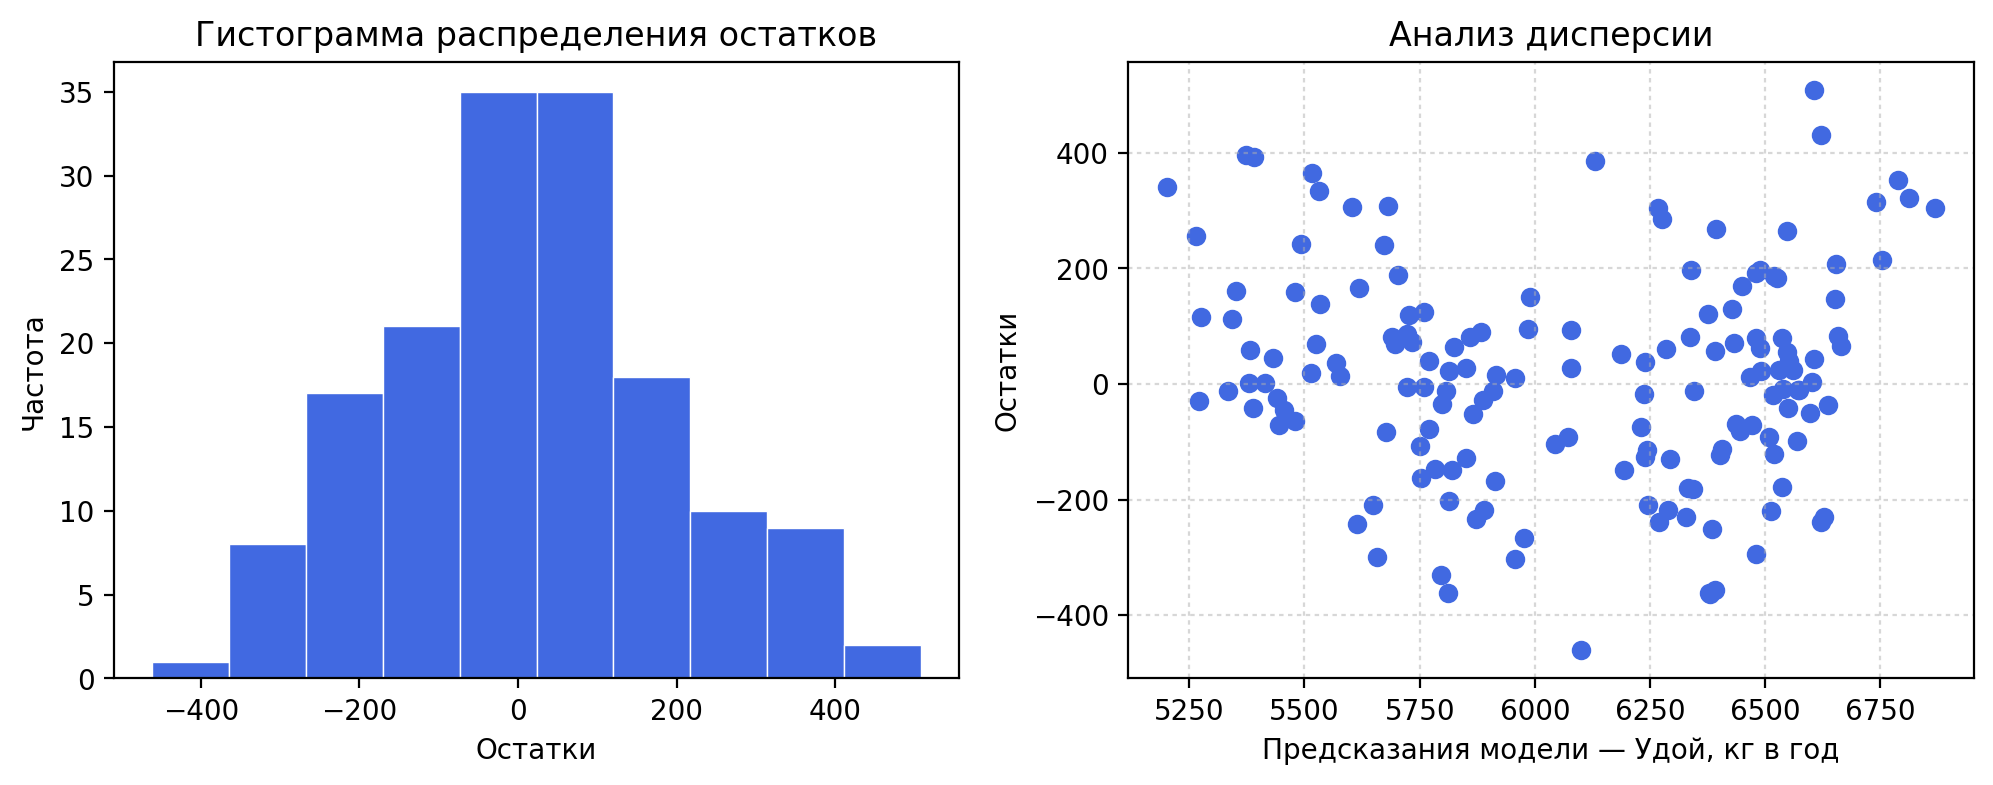

In [150]:
ModelLinearRegression.display_residuals(y_test, predictions, ferma_main_features['удой'], 'royalblue')

Посмотрим на основные метрики для оценки качества регрессионной модели.

In [152]:
metrics['Модель 3'] = ModelLinearRegression.get_metrics(y_test, predictions)
metrics['Модель 3']

{'MSE': 34362.2778933827,
 'RMSE': 185.37065003226022,
 'MAE': 144.19665221091074,
 'R²': 0.8431654640899504,
 'mean': 14.627285574725821,
 '95% интервал остатков': (-348.72610321611086, 377.9806743655625)}

Средняя абсолютная ошибка MAE уменьшилась до ~144 кг молока в год. Коэффициент детерминации R² показывает, что предсказание модели точнее, чем среднее значение целевого признака в ~84% случаев. Распределение остатков немного смещено вправо — модель чуть занижает предсказания.

### Сравнение моделей

Сравним качество двух моделей линейной регрессии, сопоставим их метрики.

In [156]:
pd.DataFrame(metrics).T

MSE        RMSE         MAE        R²       mean                      95% интервал остатков
Модель 1  47499.999455  217.944946  173.801223  0.783203   1.661755  (-426.86576659989214, 430.18927660735335)
Модель 2  36207.490016  190.282658    149.7198  0.834744    3.73964   (-370.33637491720447, 377.8156550753172)
Модель 3  34362.277893   185.37065  144.196652  0.843165  14.627286   (-348.72610321611086, 377.9806743655625)

Метрики говорят о том, что самой качественно моделью оказась третья. Однако ее использование из-за неопределенности в идентификации быков-тёзок может ухудшить результаты прогноза, несмотря на хорошие метрики на тестовых данных. 

Поэтому выберем вторую модель. В 95% процентах случаев вторая модель ошибается не более, чем на ~370 кг молока в год в меньшую сторону от истинного значения удоя, и не более, чем на ~378 кг молока в год в большую сторону.

### Прогноз удоя коров «ЭкоФермы»

С помощью второй модели спрогнозируем удой коров «ЭкоФермы», которых фермер хочет купить, из датафрейма `cow_buy`. Сначала добавим недостающие признаки. Технологи заказчика пересмотрели подход к кормлению: для новых коров планируется увеличить значения параметров корма на 5%.

In [160]:
cow_buy['эке_корма'] = ferma_main['эке_корма'].mean() * 1.05
cow_buy['протеин_в_корме'] = ferma_main['протеин_в_корме'].mean() * 1.05
cow_buy['спо_корма'] = ferma_main['спо_корма'].mean() * 1.05

Добавим дополнительные признаки (аналогично тому, как делали для тренировочной выборки).

In [162]:
first_modify_data(cow_buy)

Получим прогноз удоя коров.

In [164]:
cow_buy['удой_прогноз'] = model_2.predict(cow_buy)

Посмотрим, у скольких коров «ЭкоФермы» прогнозируется удой менее 6000 кг молока в год.

In [166]:
len(cow_buy.query('удой_прогноз < 6000'))

0

Значит, все коровы «ЭкоФермы» подойдут фермеру по критерию удоя.

## Обучение модели логистической регрессии

Обучим модель логистической регрессии для рассчета вероятности получить вкусное молоко от коровы — и с помощью лучшей модели спрогнозируем вкус молока коров, которых фермер хочет купить.

### Подготовка и обучение модели

В процессе корреляционного анализа мы выяснили, что на вкус молока могут влиять как характеристики корма и тип пастбища, помимо этого вкус молока связан с характеристиками молока.

На вкус молока может сильно влиять то, насколько оно сладкое. А причина сладости молока — содержание сахара в корме. Добавим новый признак `сахар_в корме`, характеризующий содержание сахара в корме (в граммах). Для этого умножим содержание сырого протеина в корме (в граммах) на сахаро-протеиновое соотношение.

In [172]:
def second_modify_data(data):
    data['сахар_в_корме'] = data['протеин_в_корме'] * data['спо_корма']


second_modify_data(ferma_main)

Обучим модель линейной регрессии на следующих признаках:
- количественные: `эке_корма_квадрат`, `протеин_в_корме`, `сахар_в_корме`, `жирность_молока`, `белок_в_молоке`.
- категориальные: `возраст`, `пастбище`, `спо_корма_категория`.

Для этого разобьем данные из датафрейма `ferma_main` на тренировочную и тестовую выборки. Перед обучением отасштабируем количественные признаки с помощью `StandardScaler` и кодируем категориальные признаки с помощью `OneHotEncoder`.

In [174]:
class ModelLogisticRegression:

    def __init__(self, num_col_names, cat_col_names):
        self.num_col_names = num_col_names
        self.cat_col_names = cat_col_names
        self.scaler = StandardScaler() # MinMaxScaler()
        self.encoder = OneHotEncoder(drop='first', sparse_output=False)
        self.clf = LogisticRegression()

    def __preprocessing(self, X):
        X_scaled = self.scaler.transform(X[self.num_col_names])
        X_scaled = pd.DataFrame(X_scaled, columns=self.num_col_names)
        X_ohe = self.encoder.transform(X[self.cat_col_names])
        X_ohe = pd.DataFrame(X_ohe, columns=self.encoder.get_feature_names_out())
        return pd.concat([X_scaled, X_ohe], axis=1)

    def fit(self, X, y_true):
        self.scaler = self.scaler.fit(X[self.num_col_names])
        self.encoder = self.encoder.fit(X[self.cat_col_names])
        X = self.__preprocessing(X)
        self.clf.fit(X, y_true)

    def predict(self, X, threshold=0.5):
        X = self.__preprocessing(X)
        y_proba = self.clf.predict_proba(X)[:, 1]
        return np.where(y_proba >= threshold, 1, 0)

    def predict_proba(self, X):
        X = self.__preprocessing(X)
        return self.clf.predict_proba(X)[:, 1]

    def display_confusion_matrix(y_true, y_pred):
        fig, ax = plt.subplots(1, 1, figsize=(5, 4))
        cm = confusion_matrix(y_true, y_pred)
        sns.heatmap(cm, annot=True, square=True, fmt='d', cmap='Blues_r', ax=ax)
        ax.set_title('Тепловая карта матрицы ошибок')
        ax.set_xlabel('Предсказанное значение')
        ax.set_ylabel('Реальное значение')

    def get_metrics(y_true, y_pred):
        accuracy = accuracy_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred)
        return {'accuracy': accuracy, 'recall': recall, 'precision': precision}

In [175]:
# разобьем данные на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(ferma_main.drop('вкус_молока', axis=1), 
                                                    ferma_main['вкус_молока'].apply(lambda x: 1 if x == 'вкусно' else 0), 
                                                    random_state=RANDOM_STATE)

# количественные признаки и категориальные признаки
num_col_names = ['эке_корма_квадрат', 'протеин_в_корме', 'сахар_в_корме', 'жирность_молока', 'белок_в_молоке']
cat_col_names = ['возраст', 'пастбище', 'спо_корма_категория']

# обучение модели на тренировочной выборке
model = ModelLogisticRegression(num_col_names, cat_col_names)
model.fit(X_train, y_train)

# предсказания с порогом 0.5 на тестовой выборке
predictions = model.predict(X_test, 0.5)

Посмотрим на метрики для оценки качества модели логистической регрессии.

In [177]:
ModelLogisticRegression.get_metrics(y_test, predictions)

{'accuracy': 0.6538461538461539,
 'recall': 0.8160919540229885,
 'precision': 0.6513761467889908}

Построим матрицу ошибок.

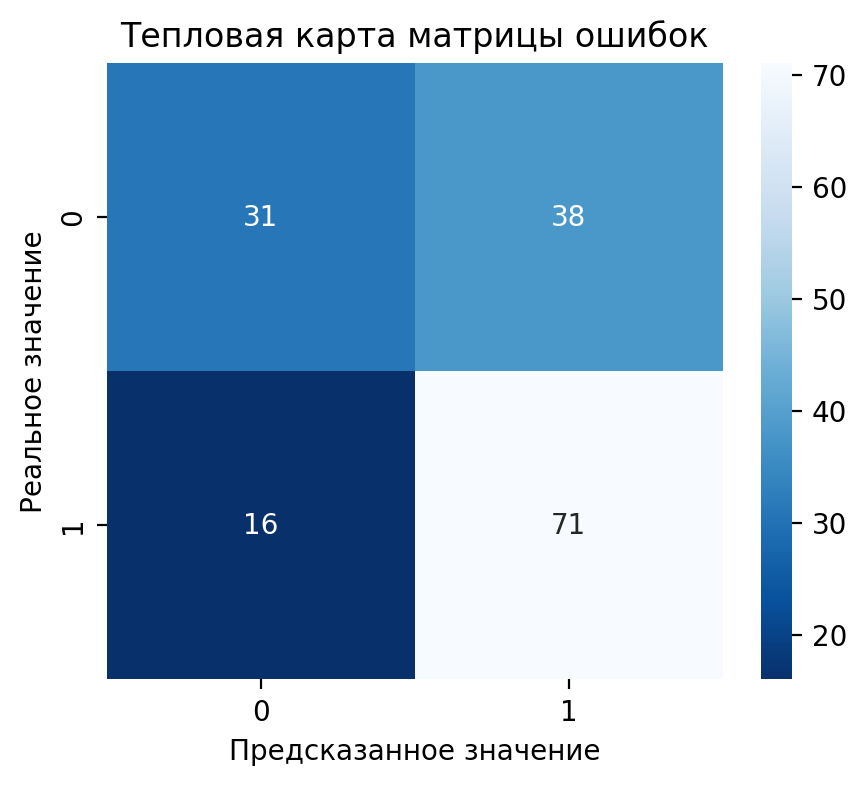

In [179]:
ModelLogisticRegression.display_confusion_matrix(y_test, predictions)

По метрике accuracy модель в тестовой выборке верно определяет вкус молока в ~65% случаев. Модель 38 раз ошибочно предсказывает, что корова будет давать вкусное молоко (ошибки первого рода), и 16 раз — что невкусное (ошибки второго рода). Поскольку главное для заказчика — вкусное молоко, нам важно уменьшить ошибки первого рода, то есть улучшить метрику precision. Для этого попробуем изменить порог принадлежности к целевому классу.

In [181]:
predictions_proba = model.predict_proba(X_test)
for threshold in np.linspace(0.5, 0.9, 41):
    metrics = ModelLogisticRegression.get_metrics(y_test, np.where(predictions_proba >= threshold, 1, 0))
    if metrics['precision'] == 1:
        display(f'Порог: {threshold}', metrics)
        break

'Порог: 0.74'

{'accuracy': 0.6025641025641025,
 'recall': 0.28735632183908044,
 'precision': 1.0}

Построим матрицу ошибок с порогом 0.74.

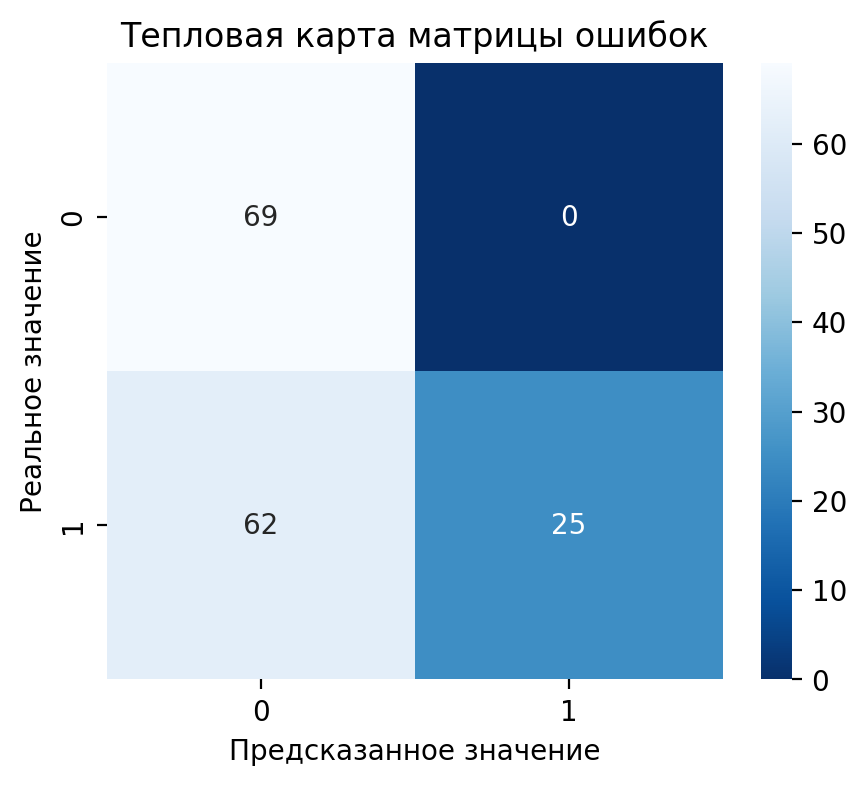

In [183]:
predictions = model.predict(X_test, 0.74)
ModelLogisticRegression.display_confusion_matrix(y_test, predictions)

С порогом 0.74 модель в тестовой выборке верно определяет вкус молока в ~60% случаев. При этом мы пропустим больше коров, дающих вкусное молоко. Однако теперь модель не делает ошибок первого рода, то есть модель перестала ошибочно предсказывать то, что молоко будет вкусное — а это главное для заказчика.

### Прогноз вкуса молока коров «ЭкоФермы»

С помощью обученной модели спрогнозируем вкус молока коров «ЭкоФермы», которых фермер хочет купить, из датафрейма `cow_buy`. Добавим дополнительный признак (аналогично тому, как делали для тренировочной выборки).

In [187]:
second_modify_data(cow_buy)

Получим прогноз вкус молока коров.

In [189]:
cow_buy['вкус_молока_прогноз'] = np.where(model.predict(cow_buy, 0.74) == 1, 'вкусно', 'не вкусно')

Посмотрим, у скольких коров «ЭкоФермы» прогнозируется невкусное молоко.

In [191]:
len(cow_buy.query('вкус_молока_прогноз == "не вкусно"'))

16

Значит, 16 коров «ЭкоФермы» не подойдут фермеру из-за вкуса молока.

## Итоговые выводы

Разработаны две прогнозные модели для молочного хозяйства «Вольный луг», обученные на данных о стаде фермера на текущий момент (всего 634 записи в датасете).
1. Первая модель прогнозирует возможный удой коровы;
2. Вторая — рассчитывает вероятность получить вкусное молоко от коровы.

**В процессе предобработки данных** серьезных проблем не выявлено. Удалены явные дубликаты в данных о стаде фермера на текущий момент (\~0.8% от общего числа записей), обработаны неявные дубликаты. Обнаружены (но не удалены) явные дубликаты в данных о коровах «ЭкоФермы», которых фермер хочет изучить перед покупкой (~20% от общего числа записей).

К результатам **исследовательского анализа данных** о стаде фермера на текущий момент можно отнести:
- Обнаружены выбросы в значениях нескольких количественных признаков (содержание белков в молоке и удой). Записи в выбросами были удалены (~1% записей).
- Обнаружена необходимость масштабирования данных — у количественных признаков разные диапазоны значений.
- Не все количественные признаки распределены нормально. Заметно, что сахаро-протеиновое соотношение в корме можно разделить на две группы — «высокое» и «низкое», также заметны несколько групп значений в содержании жиров в молоке.
- Удой коров в стаде фермера находится в границах от 5204 до 7222 кг в год, средний удой — 6127 кг в год.
- 59% коров в стаде фермера дают вкусное (по личным критериям фермера) молоко, 41% — не вкусное.

В результате **корреляционного анализа** сделано несколько выводов:
- Целевой признак `удой` имеет весьма высокую связь с возрастом, высокую связь с показателем питательности корма коровы и с содержанием жиров в молоке, заметную связь с сахаро-протеиновым соотношением в корме и породой папы, а также умеренную связь с содержанием сырого протеина в корме.
- Взаимосвязи целевого признака `удой` и количественных характеристик корма и молока нелинейные. При этом от ряда нелинейных связей можно избавиться:
    - ввести новый количественный признак, возведя показатель питательности корма коровы `эке_корма` в квадрат;
    - ввести новый категориальный признак, разделив данные на категории по уровню сахаро-протеиновое соотношения `спо_корма` (менее 0.92 и более 0.92).
- Взаимосвязи целевого признака `удой` и количественных характеристик корма и молока сильно различаются в подгруппах по породе папы коровы и по возрасту коровы (коровы до 2 лет дают мало молока независимо от других признаков).
- Наибольшая корреляция целевого признака `вкус_молока` наблюдается с сахаро-протеиновым соотношением в корме, при этом на вкус влияют и другие характеристики корма и молока, а также вораст коровы и тип пастбища.

Для прогнозирования возможного удоя коров «ЭкоФермы», которых фермер хочет купить, **разработано несколько моделей линейной регрессии**, оценено качество каждой модели и выбрана лучшая:
- В 95% процентах случаев модель ошибается не более, чем на ~370 кг молока в год в меньшую сторону от истинного значения удоя, и не более, чем на ~378 кг молока в год в большую сторону.
- Средняя абсолютная ошибка MAE показывает, что предсказание удоя в среднем отличается от истинного значения на ~190 кг молока в год.
- Коэффициент детерминации R² показывает, что предсказание модели точнее, чем среднее значение целевого признака в ~83% случаев.

Для достижения таких результатов в модель были добавлены дополнительные признаки, необходимые для исключения ряда нелинейных связей между входными и целевым параметром `удой`: показатель питательности корма коровы в квадрате и категория сахаро-протеинового соотношения.

Для прогнозирования вкуса молока коров «ЭкоФермы», которых фермер хочет купить, **разработана модель логистической регрессии**. В модель был добавлен новый признак, характеризующий содержание сахара в корме. Поскольку главное для заказчика — вкусное молоко, было важно уменьшить ошибки первого рода, то есть улучшить метрику precision. Для этого подобран такой порог принадлежности к целевому классу, при котором модель перестала ошибочно предсказывать то, что молоко будет вкусное (метрика precision равна 1).

В качестве **рекомендаций, направленных на улучшение качества прогнозных моделей**, следует:
- Добавить в датасеты информацию для однозначной идентификации быков-тёзок.
- Добавить в датасеты новые признаки, например, массу коровы и период отёла (зимнее время или весенне-осеннее).

С помощью разработанных моделей **сделан прогноз**, позволяющий отобрать коров «ЭкоФермы» двум критериям: средний удой за год — не менее 6000 килограммов, при этом молоко должно быть вкусным. В результате отбора из 20 коров «ЭкоФермы» были выбраны 4 коровы, удовлетворяющие критериям фермера.

In [195]:
col_names = ['возраст', 'порода', 'порода_папы', 'имя_папы', 'пастбище', 
             'жирность_молока', 'белок_в_молоке', 'удой_прогноз', 'вкус_молока_прогноз']
cow_buy[col_names].query('удой_прогноз >= 6000 and вкус_молока_прогноз == "вкусно"').head(20)

возраст           порода порода_папы  имя_папы   пастбище  жирность_молока  белок_в_молоке  удой_прогноз вкус_молока_прогноз
0   более_2_лет   Вис Бик Айдиал      Айдиал  Геркулес  холмистое             3.58           3.076   6544.536674              вкусно
6   более_2_лет   Вис Бик Айдиал      Айдиал  Геркулес  холмистое             3.58           3.076   6544.536674              вкусно
9   менее_2_лет  РефлешнСоверинг      Айдиал    Буйный  холмистое             3.40           3.079   6335.925073              вкусно
16  более_2_лет   Вис Бик Айдиал     Соверин  Соловчик  холмистое             3.73           3.079   6325.405999              вкусно